# NY Person Trip Predictor

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection
import warnings
import math
import time
warnings.filterwarnings('ignore')

In [3]:
path = "C:/Users/Seant/Desktop/aml_data" #edit this path to change to your path folder
#path = "/Users/weijilim/Downloads/csv"
#path = "/Users/jayneteo/Dropbox/SMU MITB/Term 2 2021/AML/Project/NHTS/csv" 

household = pd.read_csv("".join([path,'/hhpub.csv']))
person =  pd.read_csv("".join([path,'/perpub.csv']))
trip =  pd.read_csv("".join([path,'/trippub.csv']))



In [4]:
#define function 

def cat_col_prop(data, col):
    print(pd.concat([data[col].value_counts(),
          data[col].value_counts(normalize = True).mul(100)],axis = 1, keys = ('counts','percentage')))

    sns.countplot(data[col], order =  data[col].value_counts().index)

## Objective of Study

In [5]:
ny = household[household['HHSTATE']=="NY"]
ny = ny[ny['HHVEHCNT']>0]
ny_trip = trip[trip['HOUSEID'].isin(ny['HOUSEID'])]
nyorker = person[person['HOUSEID'].isin(ny['HOUSEID'])]

In [6]:
# HOSEHOLD match

ny_hh_trip = ny_trip[['HOUSEID','TDTRPNUM']].groupby(['HOUSEID']).count().reset_index()

hh_check = ny[['HOUSEID']].merge(ny_hh_trip, how = 'left')

hh_missing = sum(hh_check['TDTRPNUM'].isna())

print(str(hh_missing), ' out of ',str(len(set(ny['HOUSEID']))),' ny household no trips recorded at all',str(hh_missing/len(set(ny['HOUSEID']))*100),'%')

1411  out of  15636  ny household no trips recorded at all 9.024047070862114 %


In [7]:
# Person  rate in household

ny_trip_check = ny_trip[['HOUSEID','PERSONID','WHYTRP90']].groupby(['HOUSEID','PERSONID']).count().reset_index()
ny_check = nyorker.merge(ny_trip_check, how = 'left', left_on=['HOUSEID','PERSONID'],right_on=['HOUSEID','PERSONID'])

In [8]:
ny_check['WHYTRP90'][ny_check['WHYTRP90']>0] =1
ny_check['WHYTRP90'][ny_check['WHYTRP90'].isna()] =0

In [9]:
person_hitrate = sum(ny_check['WHYTRP90']==0)/ny_check.shape[0]*100

print('of', str(ny_check.shape[0]),' person info,',str(person_hitrate),'% did not provide any trip info')


of 32292  person info, 17.100210578471447 % did not provide any trip info


In [10]:
summ = ny_check[['HOUSEID','PERSONID','WHYTRP90']].groupby(['HOUSEID']).agg({'PERSONID':'sum',
                                                                     'WHYTRP90':'sum'}).reset_index().rename(columns = {'WHYTRP90':'TRIP_COUNTED',
                                                                                                                       'PERSONID':'HHSIZE'})
summ['percent_trips'] = summ['TRIP_COUNTED']/summ['HHSIZE'] * 100

print('average percent of household members surveyed: ',summ['percent_trips'].mean(),'%')

average percent of household members surveyed:  60.106623043559715 %


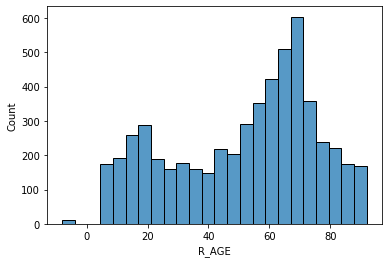

In [11]:
missing = ny_check[ny_check['WHYTRP90']==0]
sns.histplot(missing['R_AGE'])

### Goal is to create a predictive model to help predict and impute missing person trips in order to evaluate Household level trips 

## 1. Merging of Data

### 1.1. Household

In [12]:
#filtering NY Households
ny = household[household['HHSTATE'] == "NY"]

# as only studying hh with car will also filter out hh with HHVEHCNT == 0
ny = ny[ny['HHVEHCNT']>0]

In [13]:
# selection of columns based on prior background inference of potential features
ny = ny[['HOUSEID','HH_CBSA','HOMEOWN','HHSIZE','HHVEHCNT','HHFAMINC','NUMADLT','YOUNGCHILD','WRKCOUNT','MSACAT','MSASIZE','URBAN','URBANSIZE','URBRUR','LIF_CYC']]

### 1.2 Trips

In [14]:
ny_trip = trip[trip['HOUSEID'].isin(ny['HOUSEID'])]

In [15]:
# selecting trips that were done using either 3.Car, 4.SUV, 5.Van
ny_trip = ny_trip[ny_trip['TRPTRANS'].isin([3,4,5])]

In [16]:
# since only 24 lines with trip distance <= 0, removed lines
print('# of trips with dist <=0,', str(sum(ny_trip['TRPMILES']<=0)),' out of', str(len(ny_trip)))
ny_trip = ny_trip[ny_trip['TRPMILES']>0]

# of trips with dist <=0, 22  out of 87307


In [17]:
print(str(sum(ny_trip['TRVLCMIN']<=0)), ' trips missing TRVLCMIN info so will just remove since only ',str(sum(ny_trip['TRVLCMIN']<=0)/len(ny_trip)*100),"%")
ny_trip = ny_trip[ny_trip['TRVLCMIN']>0]

84  trips missing TRVLCMIN info so will just remove since only  0.09623646674686373 %


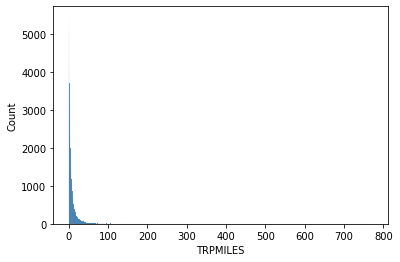

In [18]:
#Remove outlier trip miles
sns.histplot(ny_trip['TRPMILES'])
#ny_trip = ny_trip[ny_trip['TRPMILES']<40]
ny_trip = ny_trip[ny_trip['TRPMILES']<100]

In [19]:
# Summarise to Person trip counts 
ny_trip_count = ny_trip[['HOUSEID','PERSONID','TRAVDAY']].groupby(['HOUSEID','PERSONID']).agg('count').reset_index().rename(columns = {'TRAVDAY':'n_trips'})

In [20]:
ny_trip_count.head()

,HOUSEID,PERSONID,n_trips
0,30000012,1,9
1,30000082,1,5
2,30000082,2,5
3,30000380,1,3
4,30000380,2,8


In [21]:
trips_data = ny_trip[['HOUSEID','PERSONID','WHYTRP90','TRPMILES']]
trips_data['WHYTRP90'].value_counts()

# top why trips are [3,10,4,1,,8,5]

3     20107
10    17647
4     16164
1     14051
8      6467
5      5381
6      2746
11     2595
2      1257
99       22
Name: WHYTRP90, dtype: int64

In [22]:
trips_data =trips_data[trips_data['WHYTRP90'].isin([1,10,4,3,8,5])]

               counts  percentage
(-0.001, 1.0]   24049   30.130173
(2.0, 5.0]      16890   21.160906
(5.0, 11.0]     14795   18.536151
(11.0, 99.0]    14614   18.309383
(1.0, 2.0]       9469   11.863387


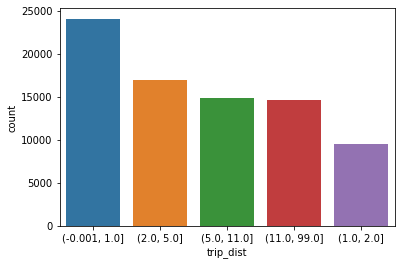

In [23]:
trips_data['round_dist']= trips_data['TRPMILES'].apply(lambda x: math.floor(x))
trips_data['trip_dist'] = pd.qcut(trips_data['round_dist'],5)
cat_col_prop(trips_data,'trip_dist')

In [24]:
trip_summary = trips_data[['HOUSEID','PERSONID','WHYTRP90','trip_dist']].groupby(['HOUSEID','PERSONID','WHYTRP90'])['trip_dist'].apply(pd.Series.mode).reset_index()
trip_summary['max_dist'] = trip_summary['trip_dist'].apply(lambda x: x.right)

In [25]:
trip_summary = trip_summary[trip_summary.groupby(['HOUSEID','PERSONID','WHYTRP90'])['max_dist'].transform(max) == trip_summary['max_dist']]

trip_summary = trip_summary[['HOUSEID','PERSONID','WHYTRP90','trip_dist']]


In [26]:
pivoted = trip_summary.pivot(index = ['HOUSEID','PERSONID'],
                  columns = 'WHYTRP90',
                  values = 'trip_dist')

trip_why_common = pd.DataFrame(pivoted.to_records()).rename(columns = {'1':'dist_to_work',
                                                       '3':'dist_to_shopping',
                                                        '4':'dist_to_family',
                                                       '5':'dist_to_school_or_church',
                                                        '8': 'dist_to_relatives',
                                                        '10':'dist_to_social'})


In [27]:
ny_trip_count = ny_trip_count.merge(trip_why_common, how = 'left',left_on = ['HOUSEID','PERSONID'],right_on = ['HOUSEID','PERSONID'])

## 1.3 People

In [28]:
# filtering people from New York
nyorker = person[person['HOUSEID'].isin(ny['HOUSEID'])]

In [29]:
# selection of columns based on prior background inference of potential features
nyorker = nyorker[['HOUSEID','PERSONID','R_AGE','EDUC','R_RACE','R_SEX','WRK_HOME','WKFTPT','OCCAT','DRIVER','TRAVDAY']]

In [30]:
ny_trip_count

,HOUSEID,PERSONID,n_trips,dist_to_work,dist_to_shopping,dist_to_family,dist_to_school_or_church,dist_to_relatives,dist_to_social
0,30000012,1,9,"(5.0, 11.0]",NaN,NaN,NaN,"(11.0, 99.0]","(2.0, 5.0]"
1,30000082,1,5,"(1.0, 2.0]",NaN,"(1.0, 2.0]",NaN,NaN,"(-0.001, 1.0]"
2,30000082,2,5,NaN,"(1.0, 2.0]",NaN,NaN,NaN,"(11.0, 99.0]"
3,30000380,1,3,NaN,"(1.0, 2.0]",NaN,NaN,NaN,NaN
4,30000380,2,8,"(-0.001, 1.0]","(1.0, 2.0]",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
22054,40793808,1,2,NaN,NaN,NaN,NaN,NaN,"(2.0, 5.0]"
22055,40793808,2,9,NaN,"(2.0, 5.0]","(2.0, 5.0]",NaN,NaN,"(1.0, 2.0]"
22056,40793808,3,5,NaN,"(2.0, 5.0]",NaN,NaN,NaN,"(-0.001, 1.0]"
22057,40793974,1,7,NaN,"(5.0, 11.0]",NaN,NaN,"(2.0, 5.0]","(2.0, 5.0]"


In [31]:
# merging of Person, Household and Trips to Person
df= nyorker.merge(ny_trip_count, how = 'left', left_on = ['HOUSEID','PERSONID'],right_on = ['HOUSEID','PERSONID'])
df = df.merge(ny, how = 'left', left_on = 'HOUSEID', right_on = 'HOUSEID')

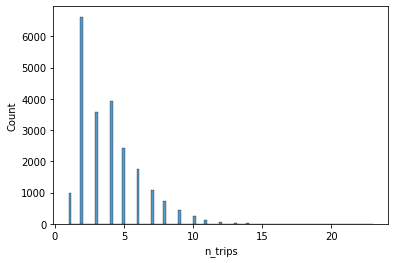

In [32]:
# Replace NA trip counts with 0
sns.histplot(df['n_trips'])
df['n_trips'][df['n_trips'].isna()] = 0
#df = df[df['n_trips']>0]
df = df[df['n_trips']<10]

In [33]:
[c for c in df]

['HOUSEID',
 'PERSONID',
 'R_AGE',
 'EDUC',
 'R_RACE',
 'R_SEX',
 'WRK_HOME',
 'WKFTPT',
 'OCCAT',
 'DRIVER',
 'TRAVDAY',
 'n_trips',
 'dist_to_work',
 'dist_to_shopping',
 'dist_to_family',
 'dist_to_school_or_church',
 'dist_to_relatives',
 'dist_to_social',
 'HH_CBSA',
 'HOMEOWN',
 'HHSIZE',
 'HHVEHCNT',
 'HHFAMINC',
 'NUMADLT',
 'YOUNGCHILD',
 'WRKCOUNT',
 'MSACAT',
 'MSASIZE',
 'URBAN',
 'URBANSIZE',
 'URBRUR',
 'LIF_CYC']

In [34]:
df.shape

(31782, 32)

## Reason for Model

In [35]:
ny_trip_count

,HOUSEID,PERSONID,n_trips,dist_to_work,dist_to_shopping,dist_to_family,dist_to_school_or_church,dist_to_relatives,dist_to_social
0,30000012,1,9,"(5.0, 11.0]",NaN,NaN,NaN,"(11.0, 99.0]","(2.0, 5.0]"
1,30000082,1,5,"(1.0, 2.0]",NaN,"(1.0, 2.0]",NaN,NaN,"(-0.001, 1.0]"
2,30000082,2,5,NaN,"(1.0, 2.0]",NaN,NaN,NaN,"(11.0, 99.0]"
3,30000380,1,3,NaN,"(1.0, 2.0]",NaN,NaN,NaN,NaN
4,30000380,2,8,"(-0.001, 1.0]","(1.0, 2.0]",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
22054,40793808,1,2,NaN,NaN,NaN,NaN,NaN,"(2.0, 5.0]"
22055,40793808,2,9,NaN,"(2.0, 5.0]","(2.0, 5.0]",NaN,NaN,"(1.0, 2.0]"
22056,40793808,3,5,NaN,"(2.0, 5.0]",NaN,NaN,NaN,"(-0.001, 1.0]"
22057,40793974,1,7,NaN,"(5.0, 11.0]",NaN,NaN,"(2.0, 5.0]","(2.0, 5.0]"


In [36]:
ny_trip_check = ny_trip[['HOUSEID','PERSONID','WHYTRP90']].groupby(['HOUSEID','PERSONID']).count().reset_index()
ny_check = nyorker.merge(ny_trip_check, how = 'left', left_on=['HOUSEID','PERSONID'],right_on=['HOUSEID','PERSONID'])

In [37]:
ny_check['WHYTRP90'][ny_check['WHYTRP90']>0] =1
ny_check['WHYTRP90'][ny_check['WHYTRP90'].isna()] =0

In [38]:
hh_rate = ny_check.groupby(['HOUSEID']).agg({'HOUSEID':'count',
                                  'WHYTRP90':'sum'})

hh_hitrate = sum(hh_rate['WHYTRP90']==0)/hh_rate.shape[0]*100

print('of ',str(hh_rate.shape[0]),' households, ',str(hh_hitrate), '% did not provide any trip info')

of  15636  households,  18.367869020209774 % did not provide any trip info


In [39]:
person_hitrate = sum(ny_check['WHYTRP90']==0)/ny_check.shape[0]*100

print('of', str(ny_check.shape[0]),' person info,',str(person_hitrate),'% did not provide any trip info')


of 32292  person info, 31.688963210702344 % did not provide any trip info


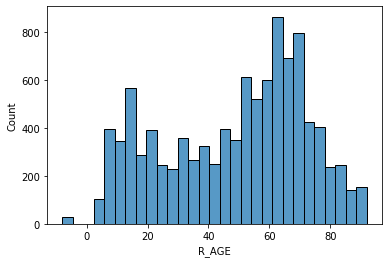

In [40]:
sns.histplot(ny_check['R_AGE'][ny_check['WHYTRP90']==0])

# not only those too young missing

### Therefore to create predictive model to help 'fill up' missing trip info to provide household level trip estimates. 

other reccommendation: for future survey can get volunteer to provide some of the key features of family members (e.g. dist to workplace or school) to help provide estimate of houshold total trips

## 2. EDA & Feature Engineering 

### 2.1. Train, Test, Split

In [41]:
x_col = [c for c in df if c not in ["HOUSEID","PERSONID","n_trips"]]
x_df = df[x_col]
y_df = df['n_trips']

x_train , x_test, y_train, y_test = model_selection.train_test_split(x_df, y_df, test_size = 0.2, random_state = 888)

In [42]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25425 entries, 19406 to 10938
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype            
---  ------                    --------------  -----            
 0   R_AGE                     25425 non-null  int64            
 1   EDUC                      25425 non-null  int64            
 2   R_RACE                    25425 non-null  int64            
 3   R_SEX                     25425 non-null  int64            
 4   WRK_HOME                  25425 non-null  int64            
 5   WKFTPT                    25425 non-null  int64            
 6   OCCAT                     25425 non-null  int64            
 7   DRIVER                    25425 non-null  int64            
 8   TRAVDAY                   25425 non-null  int64            
 9   dist_to_work              5541 non-null   interval[float64]
 10  dist_to_shopping          7272 non-null   interval[float64]
 11  dist_to_family            5551 non-nu

### 2.2. Feature Engineering

#### Age (R_AGE)

65 count of people with no age.  0.00029519289720475033 %.


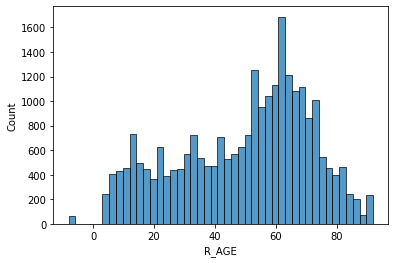

In [43]:
print(str(sum(x_train['R_AGE']<0)), "count of people with no age. ",str(sum(nyorker['R_AGE']<0)/person.shape[0]),"%.")

sns.histplot(x_train['R_AGE'])

# impute missing values (<0) with mean age
mean_age = round(x_train['R_AGE'][x_train['R_AGE']>0].mean())
x_train['R_AGE'][x_train['R_AGE']<0] = mean_age
x_test['R_AGE'][x_test['R_AGE']<0] = mean_age

In [44]:
x_train['AGE_bins']= 'NA'
x_train.loc[x_train['R_AGE'].between(5,15,inclusive = True), 'AGE_bins'] = "5_to_15"
x_train.loc[x_train['R_AGE'].between(16,25,inclusive = True), 'AGE_bins'] = "16_to_25"
x_train.loc[x_train['R_AGE'].between(26,35,inclusive = True), 'AGE_bins'] = "26_to_35"
x_train.loc[x_train['R_AGE'].between(36,45,inclusive = True), 'AGE_bins'] = "36_to_45"
x_train.loc[x_train['R_AGE'].between(46,55,inclusive = True), 'AGE_bins'] = "46_to_55"
x_train.loc[x_train['R_AGE'].between(56,65,inclusive = True), 'AGE_bins'] = "56_to_65"
x_train.loc[x_train['R_AGE'].between(66,75,inclusive = True), 'AGE_bins'] = "66_to_75"
x_train.loc[x_train['R_AGE']>75, 'AGE_bins'] = "more_than_75"

x_test['AGE_bins']= 'NA'
x_test.loc[x_test['R_AGE'].between(5,15,inclusive = True), 'AGE_bins'] = "5_to_15"
x_test.loc[x_test['R_AGE'].between(16,25,inclusive = True), 'AGE_bins'] = "16_to_25"
x_test.loc[x_test['R_AGE'].between(26,35,inclusive = True), 'AGE_bins'] = "26_to_35"
x_test.loc[x_test['R_AGE'].between(36,45,inclusive = True), 'AGE_bins'] = "36_to_45"
x_test.loc[x_test['R_AGE'].between(46,55,inclusive = True), 'AGE_bins'] = "46_to_55"
x_test.loc[x_test['R_AGE'].between(56,65,inclusive = True), 'AGE_bins'] = "56_to_65"
x_test.loc[x_test['R_AGE'].between(66,75,inclusive = True), 'AGE_bins'] = "66_to_75"
x_test.loc[x_test['R_AGE']>75, 'AGE_bins'] = "more_than_75"


              counts  percentage
56_to_65        5534   21.765978
66_to_75        4356   17.132743
46_to_55        3724   14.647001
5_to_15         2491    9.797443
26_to_35        2466    9.699115
36_to_45        2436    9.581121
more_than_75    2322    9.132743
16_to_25        2096    8.243854


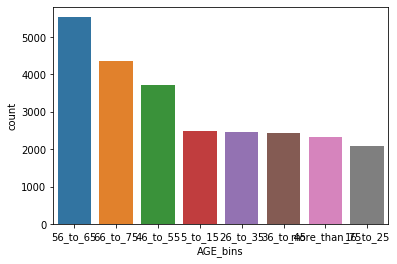

In [45]:
cat_col_prop(x_train,'AGE_bins')

#### Educational Attainment (EDUC)

    counts  percentage
 3    6293   24.751229
 5    5612   22.072763
 2    4965   19.528024
 4    4870   19.154376
-1    2002    7.874140
 1    1668    6.560472
-7      10    0.039331
-8       5    0.019666


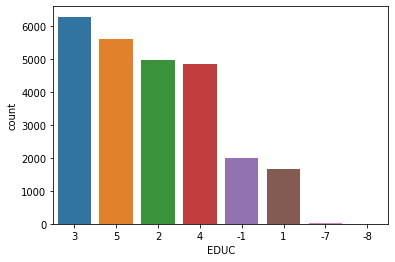

In [46]:
cat_col_prop(x_train,'EDUC')
# approx 8% missing values (<0). To take note of but will addresss in one-hot encoding

#### Race (R_RACE)

     counts  percentage
 1    22734   89.415929
 3      834    3.280236
 2      794    3.122911
 6      530    2.084562
 97     323    1.270403
-7      113    0.444444
 4       69    0.271386
 5       14    0.055064
-8       14    0.055064


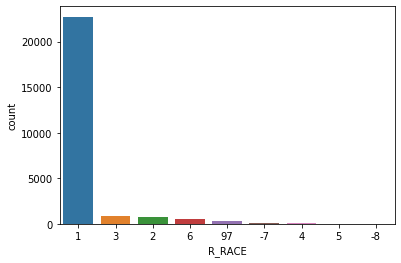

In [47]:
cat_col_prop(x_train,'R_RACE')
# approx 1% missing values (<0). To take note of but will address in one-hot encoding
# Significant proportion of members 'white'

#### Gender (R_SEX)

    counts  percentage
 2   13302   52.318584
 1   12098   47.583088
-7      21    0.082596
-8       4    0.015733


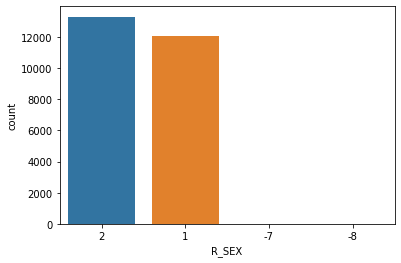

In [48]:
cat_col_prop(x_train, 'R_SEX')
# <1% missing values. To take note but will be addressed in one-hot encoding

#### Work From Home (WRK_HOME)

    counts  percentage
-1   12738   50.100295
 2   10825   42.576205
 1    1371    5.392330
-9     490    1.927237
-7       1    0.003933


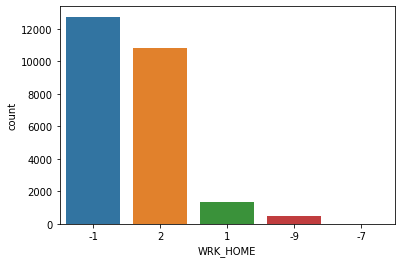

In [49]:
cat_col_prop(x_train,'WRK_HOME')
# Significant proportion -1 (50%) which is the appropriate skip (due to not working) - to address in one-hot

#### Work - Part Time or Full Time (WKFTPT)

    counts  percentage
-1   13228   52.027532
 1    9442   37.136676
 2    2747   10.804326
-7       6    0.023599
-8       2    0.007866


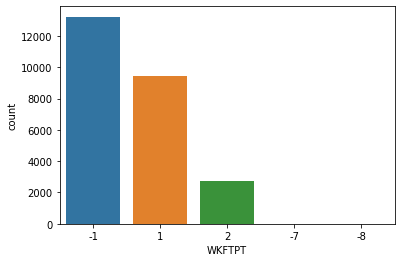

In [50]:
cat_col_prop(x_train,'WKFTPT')
# Significant proportion -1 (52%) which is the appropriate skip (due to not working) - to address in one-hot

#### Job Category (OCCAT)

     counts  percentage
-1    12738   50.100295
 4     6694   26.328417
 1     2585   10.167158
 3     1482    5.828909
 2     1415    5.565388
-9      490    1.927237
 97      15    0.058997
-8        4    0.015733
-7        2    0.007866


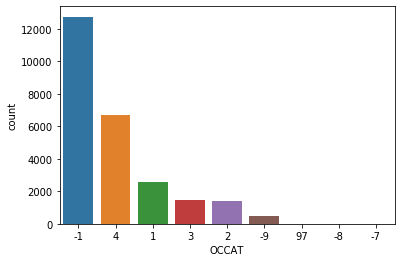

In [51]:
cat_col_prop(x_train,'OCCAT')
# Significant proportion -1 (50%) which is the appropriate skip (due to not working) - to address in one-hot

#### Driver Status (DRIVER)

    counts  percentage
 1   21439   84.322517
-1    2265    8.908555
 2    1721    6.768928


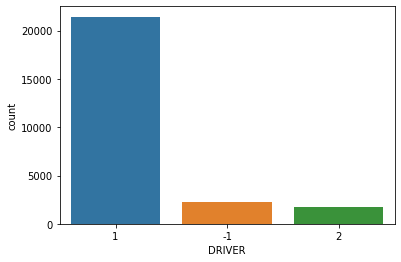

In [52]:
cat_col_prop(x_train,'DRIVER')

#Significant proportion -1 (8.7%) (due to too young) - to address in one-hot encoding
#sns.boxplot(data = x_train, x='DRIVER',y='AGE_bins')

#### Travel Day (TRAVDAY)

   counts  percentage
1    3763   14.800393
2    3720   14.631268
7    3716   14.615536
5    3636   14.300885
6    3574   14.057030
3    3547   13.950836
4    3469   13.644051


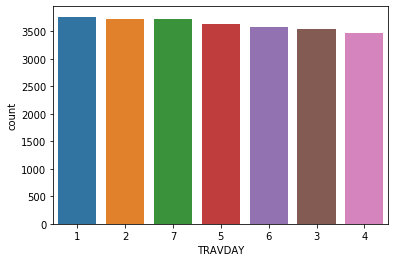

In [53]:
cat_col_prop(x_train,'TRAVDAY')

#### Core Based Statiscal Area FIPS code (HH_CBSA)

       counts  percentage
XXXXX   15006   59.020649
35620    7719   30.359882
40380    1467    5.769912
15380    1233    4.849558


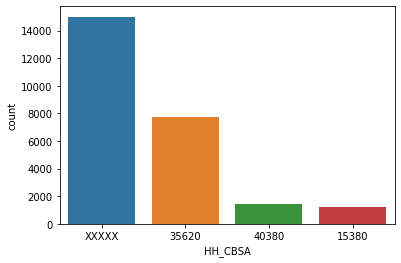

In [54]:
#Core Based Statistical Area (CBSA) FIPS code for the respondent's home address

cat_col_prop(x_train,'HH_CBSA')

# significant number of households under the 'XXXXX=Suppressed, in an MSA of less than 1 million ' category

####  Home Ownership (HOMEOWN)

     counts  percentage
 1    21452   84.373648
 2     3776   14.851524
 97     196    0.770895
-7        1    0.003933


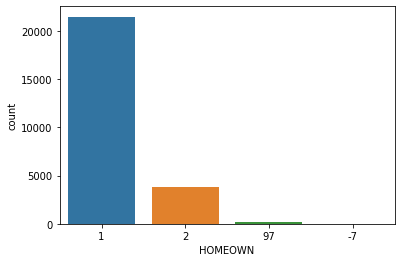

In [55]:
cat_col_prop(x_train,'HOMEOWN')
#Small count with missing value 2. to address in one-hot encoding

#### Household Vehicle Count (HHVEHCNT)

    counts  percentage
2    11356   44.664700
1     6591   25.923304
3     4623   18.182891
4     1829    7.193707
5      662    2.603736
6      245    0.963618
7       80    0.314651
8       22    0.086529
11       9    0.035398
9        6    0.023599
12       2    0.007866
________
new HHVEHCNT
    counts  percentage
2    11356   44.664700
1     6591   25.923304
3     4623   18.182891
>3    2855   11.229105


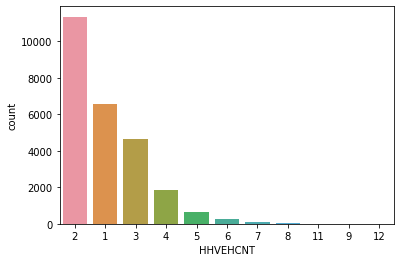

In [56]:
#count of household vehicles

cat_col_prop(x_train,'HHVEHCNT')

# as group size significantly smaller from 4 and above to bin to a single group

x_train['HHVEHCNT'][x_train['HHVEHCNT']>3] = ">3"
x_test['HHVEHCNT'][x_test['HHVEHCNT']>3] = ">3"

print("________")
print("new HHVEHCNT")
print(pd.concat([x_train['HHVEHCNT'].value_counts(),
          x_train['HHVEHCNT'].value_counts(normalize = True).mul(100)],axis = 1, keys = ('counts','percentage'))
    )

#### Family Income (HHFAMINC)

     counts  percentage
 6     4580   18.013766
 7     3829   15.059980
 8     3144   12.365782
 5     2664   10.477876
 4     1974    7.764012
 11    1874    7.370698
 9     1860    7.315634
 10    1780    7.000983
 3     1590    6.253687
-7      742    2.918387
 2      732    2.879056
 1      557    2.190757
-8       97    0.381514
-9        2    0.007866


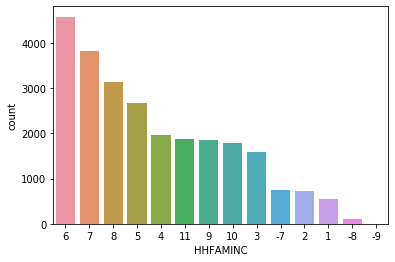

In [57]:
cat_col_prop(x_train,'HHFAMINC')
# approx 3% missing (<0) to address in one-hot encoding

#### Adult Ratio  (NUMADLT)

    counts  percentage
2    16118   63.394297
1     4266   16.778761
3     3501   13.769912
4     1192    4.688299
5      286    1.124877
6       38    0.149459
7       11    0.043265
10       7    0.027532
8        6    0.023599


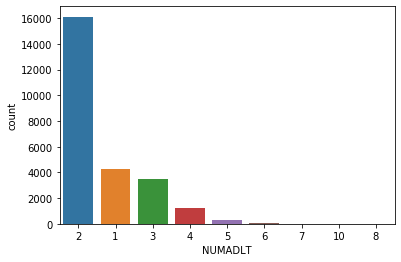

In [58]:
cat_col_prop(x_train, 'NUMADLT')
#no missing values

Before
          counts  percentage
1.000000   17591   69.187807
0.500000    2802   11.020649
0.666667    1929    7.587021
0.400000     895    3.520157
0.750000     656    2.580138
0.333333     509    2.001967
0.600000     378    1.486726
0.800000     213    0.837758
0.250000      93    0.365782
0.285714      78    0.306785
0.714286      53    0.208456
0.833333      42    0.165192
0.428571      40    0.157325
0.571429      34    0.133727
0.375000      20    0.078663
0.222222      17    0.066863
0.625000      17    0.066863
0.200000      15    0.058997
0.444444      11    0.043265
0.166667      10    0.039331
0.700000       7    0.027532
0.142857       6    0.023599
0.857143       5    0.019666
0.363636       4    0.015733

After
               counts  percentage
1               17591   69.187807
more_than_0.5    6136   24.133727
less_than_0.5    1698    6.678466


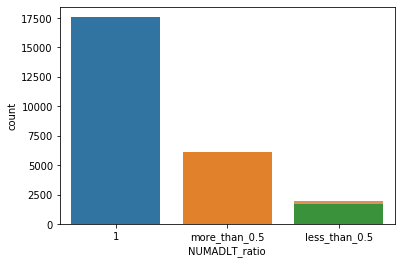

In [59]:
#Convert against proportion of Household size
x_train['NUMADLT'] = x_train['NUMADLT']/x_train['HHSIZE']
x_test['NUMADLT'] = x_test['NUMADLT']/x_test['HHSIZE']
print('Before')
cat_col_prop(x_train,'NUMADLT')
#significant number of varying factors
#to bin into groups
x_train['NUMADLT_ratio'] = 'NA'
x_train.loc[x_train['NUMADLT']==0, 'NUMADLT_ratio'] = '0'
x_train.loc[x_train['NUMADLT'].between(0,0.5,inclusive = False),'NUMADLT_ratio'] = 'less_than_0.5'
x_train.loc[x_train['NUMADLT'].between(0.5,1, inclusive = True),'NUMADLT_ratio'] = 'more_than_0.5'
x_train.loc[x_train['NUMADLT']==1,'NUMADLT_ratio'] ='1'
print('')
print('After')
cat_col_prop(x_train,'NUMADLT_ratio')


x_test['NUMADLT_ratio'] = 'NA'
x_test.loc[x_test['NUMADLT']==0, 'NUMADLT_ratio'] = '0'
x_test.loc[x_test['NUMADLT'].between(0,0.5,inclusive = False),'NUMADLT_ratio'] = 'less_than_0.5'
x_test.loc[x_test['NUMADLT'].between(0.5,1, inclusive = True),'NUMADLT_ratio'] = 'more_than_0.5'
x_test.loc[x_test['NUMADLT']==1,'NUMADLT_ratio'] ='1'

#### Young Child Ratio (YOUNGCHILD)

   counts  percentage
0   23182   91.177974
1    1671    6.572271
2     518    2.037365
3      49    0.192724
5       4    0.015733
4       1    0.003933


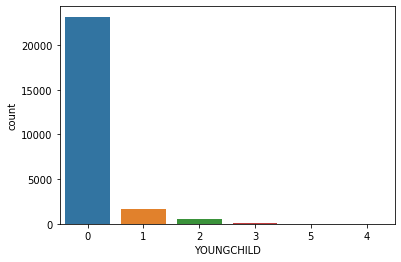

In [60]:
cat_col_prop(x_train,'YOUNGCHILD')

               counts  percentage
0               23182   91.177974
less_than_0.5    1938    7.622419
more_than_0.5     305    1.199607


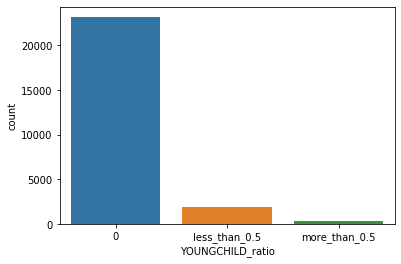

In [61]:
#Convert against proportion of Household size

x_train['YOUNGCHILD'] = x_train['YOUNGCHILD']/x_train['HHSIZE']
x_test['YOUNGCHILD'] = x_test['YOUNGCHILD']/x_test['HHSIZE']

#Bin to groups
x_train['YOUNGCHILD_ratio'] = 'NA'
x_train.loc[x_train['YOUNGCHILD']==0,'YOUNGCHILD_ratio']= '0'
x_train.loc[x_train['YOUNGCHILD'].between(0,0.5,inclusive = False),'YOUNGCHILD_ratio'] = 'less_than_0.5'
x_train.loc[x_train['YOUNGCHILD'].between(0.5,1, inclusive = True),'YOUNGCHILD_ratio'] = 'more_than_0.5'
x_train.loc[x_train['YOUNGCHILD']==1,'YOUNGCHILD_ratio'] ='1'
 

cat_col_prop(x_train,'YOUNGCHILD_ratio')    

x_test['YOUNGCHILD_ratio'] = 'NA'
x_test.loc[x_test['YOUNGCHILD']==0,'YOUNGCHILD_ratio']= '0'
x_test.loc[x_test['YOUNGCHILD'].between(0,0.5,inclusive = False),'YOUNGCHILD_ratio'] = 'less_than_0.5'
x_test.loc[x_test['YOUNGCHILD'].between(0.5,1, inclusive = True),'YOUNGCHILD_ratio'] = 'more_than_0.5'
x_test.loc[x_test['YOUNGCHILD']==1,'YOUNGCHILD_ratio'] ='1'
 


#### Worker Count Proportion (WRKCOUNT)

   counts  percentage
2    8775   34.513274
1    7693   30.257620
0    6707   26.379548
3    1671    6.572271
4     513    2.017699
5      55    0.216323
7       6    0.023599
6       5    0.019666


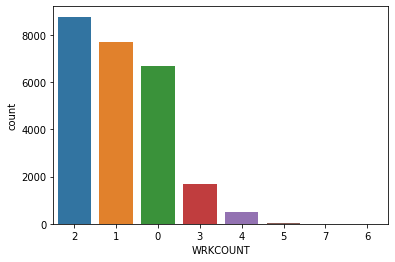

In [62]:
cat_col_prop(x_train,'WRKCOUNT')

               counts  percentage
more_than_0.5    8284   32.582104
0                6707   26.379548
1                6416   25.235005
less_than_0.5    4018   15.803343


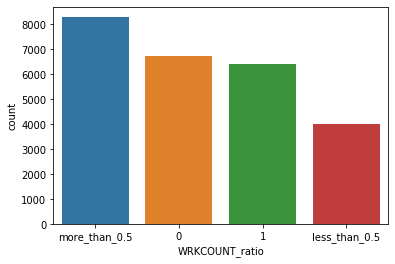

In [63]:
#Convert against proportion of Household size

x_train['WRKCOUNT'] = x_train['WRKCOUNT']/x_train['HHSIZE']
x_test['WRKCOUNT'] = x_test['WRKCOUNT']/x_test['HHSIZE']

#Bin to groups
x_train['WRKCOUNT_ratio'] = 'NA'
x_train.loc[x_train['WRKCOUNT']==0,'WRKCOUNT_ratio']= '0'
x_train.loc[x_train['WRKCOUNT'].between(0,0.5,inclusive = False),'WRKCOUNT_ratio'] = 'less_than_0.5'
x_train.loc[x_train['WRKCOUNT'].between(0.5,1, inclusive = True),'WRKCOUNT_ratio'] = 'more_than_0.5'
x_train.loc[x_train['WRKCOUNT']==1,'WRKCOUNT_ratio'] ='1'

cat_col_prop(x_train,'WRKCOUNT_ratio')

x_test['WRKCOUNT_ratio'] = 'NA'
x_test.loc[x_test['WRKCOUNT']==0,'WRKCOUNT_ratio']= '0'
x_test.loc[x_test['WRKCOUNT'].between(0,0.5,inclusive = False),'WRKCOUNT_ratio'] = 'less_than_0.5'
x_test.loc[x_test['WRKCOUNT'].between(0.5,1, inclusive = True),'WRKCOUNT_ratio'] = 'more_than_0.5'
x_test.loc[x_test['WRKCOUNT']==1,'WRKCOUNT_ratio'] ='1'

 

#### Household Size (HHSIZE)

Before
    counts  percentage
2    10847   42.662734
3     4371   17.191740
4     3952   15.543756
1     3675   14.454277
5     1663    6.540806
6      537    2.112094
7      220    0.865290
8       91    0.357915
9       39    0.153392
10      26    0.102262
11       4    0.015733

After
         counts  percentage
2         10847   42.662734
above_3    6532   25.691249
3          4371   17.191740
1          3675   14.454277


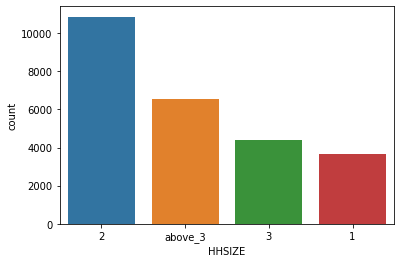

In [64]:
#count of household members
print("Before")
cat_col_prop(x_train,'HHSIZE')

# to bin tail HHSIZE

x_train['HHSIZE'][x_train['HHSIZE']>3] = "above_3"

print("")
print("After")

cat_col_prop(x_train,'HHSIZE')

x_test['HHSIZE'][x_test['HHSIZE']>3] = " above_3"

#### Metropolitan Statistical Area (MSACAT)


   counts  percentage
3   10912   42.918387
1    7719   30.359882
4    4094   16.102262
2    2700   10.619469


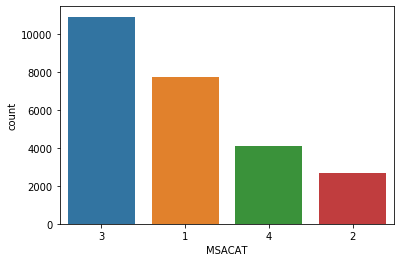

In [65]:
cat_col_prop(x_train,'MSACAT')
             
#no missing values and relatively proportional distribution

#### Population size of MSA (MSASIZE)

   counts  percentage
5    7719   30.359882
1    6322   24.865290
6    4094   16.102262
3    3471   13.651917
4    2700   10.619469
2    1119    4.401180


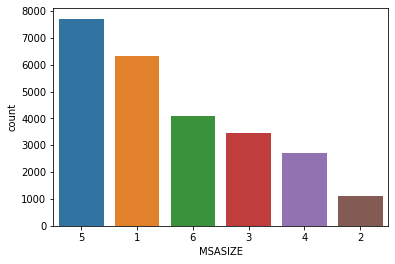

In [66]:
cat_col_prop(x_train,'MSASIZE')
             
#no missing values and relatively proportional distribution

#### House in Urban or Rural Area (URBAN)

Before
   counts  percentage
1   14285   56.184857
4    8638   33.974435
2    2497    9.821042
3       5    0.019666

After
       counts  percentage
urban   16782     66.0059
rural    8643     33.9941


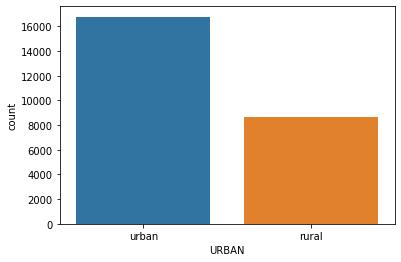

In [67]:
print('Before')
cat_col_prop(x_train,'URBAN')

# combine 1 and 2 (in an urban area and in an urban cluster ) & combine 3 and 4 (surround by urban and not in urban)

x_train['URBAN'][x_train['URBAN'].isin([1,2])] = 'urban'
x_train['URBAN'][x_train['URBAN'].isin([3,4])] = 'rural'

print("")
print('After')

cat_col_prop(x_train, 'URBAN')

x_test['URBAN'][x_test['URBAN'].isin([1,2])] = 'urban'
x_test['URBAN'][x_test['URBAN'].isin([3,4])] = 'rural'

#### URBANSIZE

   counts  percentage
6   11140   43.815143
5    4990   19.626352
1    3821   15.028515
3    2868   11.280236
2    2606   10.249754


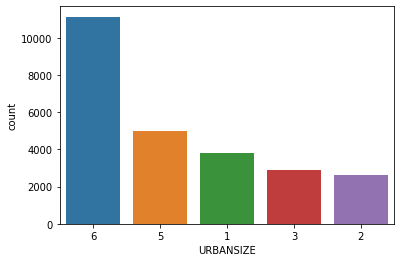

In [68]:
#06 = not in an urbanised area 
#05 - 1 million with heavy rail 

#Relatively proportional classes
cat_col_prop(x_train,'URBANSIZE')

#### URBRUR

   counts  percentage
1   16782     66.0059
2    8643     33.9941


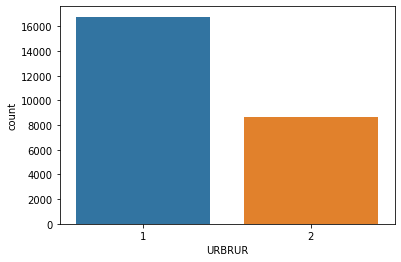

In [69]:
cat_col_prop(x_train,'URBRUR')
# missing values nor disproportion

#### LIF_CYC 

    counts  percentage
10    7019   27.606686
2     5796   22.796460
6     3870   15.221239
4     2543   10.001967
1     1937    7.618486
9     1738    6.835792
8     1693    6.658800
5      460    1.809243
7      211    0.829892
3      158    0.621436


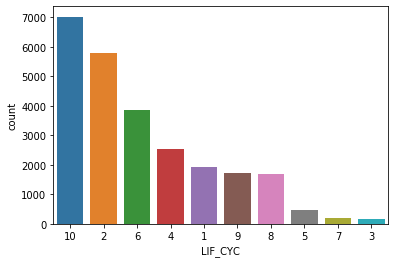

In [70]:
cat_col_prop(x_train,"LIF_CYC")

# No major disproportion

## 3. One-Hot- Encoding

In [71]:
x_train.dtypes

R_AGE                                   int64
EDUC                                    int64
R_RACE                                  int64
R_SEX                                   int64
WRK_HOME                                int64
WKFTPT                                  int64
OCCAT                                   int64
DRIVER                                  int64
TRAVDAY                                 int64
dist_to_work                interval[float64]
dist_to_shopping            interval[float64]
dist_to_family              interval[float64]
dist_to_school_or_church    interval[float64]
dist_to_relatives           interval[float64]
dist_to_social              interval[float64]
HH_CBSA                                object
HOMEOWN                                 int64
HHSIZE                                 object
HHVEHCNT                               object
HHFAMINC                                int64
NUMADLT                               float64
YOUNGCHILD                        

In [72]:
to_obj = ['EDUC','R_RACE','AGE_bins','HHFAMINC','HOMEOWN','R_SEX','TRAVDAY','WRK_HOME','WKFTPT','OCCAT','DRIVER','MSACAT','MSASIZE','URBAN','URBANSIZE','URBRUR','LIF_CYC','dist_to_work','dist_to_shopping','dist_to_family','dist_to_school_or_church','dist_to_relatives','dist_to_social']

x_train[to_obj] = x_train[to_obj].astype(str)
x_test[to_obj]= x_test[to_obj].astype(str)

x_train.drop(['R_AGE'], axis = 1, inplace =True)
x_test.drop(['R_AGE'],axis = 1, inplace = True)

In [73]:
one_hot_col = [c for c in x_train if x_train[c].dtypes == 'O' ]
x_train = pd.concat([x_train,pd.get_dummies(x_train[one_hot_col],prefix = one_hot_col)],axis = 1)
x_train.drop(one_hot_col, axis = 1, inplace = True)

x_test = pd.concat([x_test,pd.get_dummies(x_test[one_hot_col],prefix = one_hot_col)],axis = 1)
x_test.drop(one_hot_col, axis = 1, inplace = True)

In [74]:
#drop all negative value columns  

na_cols_train =[c for c in x_train if ('NA' in c) or ('-' in c) or ('nan' in c)]

x_train.drop(na_cols_train, axis = 1, inplace = True)


na_cols_test =[c for c in x_test if ('NA' in c) or ('-' in c) or ('nan' in c)]
x_test.drop(na_cols_test, axis = 1 , inplace = True)

In [75]:

dist_cols = [c for c in x_train if ('dist' in c)]

x_train_with_dist = x_train[dist_cols]
x_test_with_dist = x_test[dist_cols]

x_train.drop(dist_cols, axis =1, inplace = True)
x_test.drop(dist_cols, axis =1, inplace = True)


#y_train = y_train.astype('int64')
#y_test = y_test.astype('int64')

In [76]:
x_train.shape

(25425, 108)

In [77]:

x_train_with_dist = pd.concat([x_train,x_train_with_dist],axis=1)
x_test_with_dist = pd.concat([x_test,x_test_with_dist],axis=1)


In [78]:
dist_dict = {'dist_to_work_(1.0, 2.0]':'dist_to_work_between_1_and_2',
            'dist_to_work_(11.0, 99.0]':'dist_to_work_more_than_11',
            'dist_to_work_(2.0, 5.0]':'dist_to_work_between_2_and_5',
            'dist_to_work_(5.0, 11.0]':'dist_to_work_between_5_and_11',
             'dist_to_shopping_(1.0, 2.0]':'dist_to_shopping_between_1_and_2',
             'dist_to_shopping_(11.0, 99.0]':'dist_to_shopping_more_than_11',
             'dist_to_shopping_(2.0, 5.0]':'dist_to_shopping_between_2_and_5',
             'dist_to_shopping_(5.0, 11.0]':'dist_to_shopping_between_5_and_11',
             'dist_to_family_(1.0, 2.0]':'dist_to_family_between_1_and_2',
             'dist_to_family_(11.0, 99.0]':'dist_to_family_greater_than_11',
             'dist_to_family_(2.0, 5.0]':'dist_to_family_between_2_and_5',
             'dist_to_family_(5.0, 11.0]':'dist_to_family_between_5_and_11',
             'dist_to_school_or_church_(1.0, 2.0]':'dist_to_school_or_church_between_1_and_2',
             'dist_to_school_or_church_(11.0, 99.0]':'dist_to_school_or_church_greater_than_11',
             'dist_to_school_or_church_(2.0, 5.0]':'dist_to_school_or_church_between_2_and_5',
             'dist_to_school_or_church_(5.0, 11.0]':'dist_to_school_or_church_between_5_and_11',
             'dist_to_relatives_(1.0, 2.0]':'dist_to_relatvies_between_1_and_2',
             'dist_to_relatives_(11.0, 99.0]':'dist_to_relatvies_greater_than_11',
             'dist_to_relatives_(2.0, 5.0]':'dist_to_relatvies_between_2_and_5',
             'dist_to_relatives_(5.0, 11.0]':'dist_to_relatvies_between_5_and_11',
             'dist_to_social_(1.0, 2.0]':'dist_to_social_between_1_and_2',
             'dist_to_social_(11.0, 99.0]':'dist_to_social_greater_than_11',
             'dist_to_social_(2.0, 5.0]':'dist_to_social_between_2_and_5',
             'dist_to_social_(5.0, 11.0]':'dist_to_social_between_5_and_11'}

dist_cols = [c for c in x_train_with_dist if 'dist' in c]

x_train_with_dist.rename(columns=dist_dict,inplace = True)
x_test_with_dist.rename(columns = dist_dict, inplace = True)

In [79]:
x_test

,NUMADLT,YOUNGCHILD,WRKCOUNT,EDUC_1,EDUC_2,EDUC_3,EDUC_4,EDUC_5,R_RACE_1,R_RACE_2,...,NUMADLT_ratio_1,NUMADLT_ratio_less_than_0.5,NUMADLT_ratio_more_than_0.5,YOUNGCHILD_ratio_0,YOUNGCHILD_ratio_less_than_0.5,YOUNGCHILD_ratio_more_than_0.5,WRKCOUNT_ratio_0,WRKCOUNT_ratio_1,WRKCOUNT_ratio_less_than_0.5,WRKCOUNT_ratio_more_than_0.5
27442,0.500000,0.25,0.250000,1,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0,1,0
24393,1.000000,0.00,1.000000,0,0,0,1,0,1,0,...,1,0,0,1,0,0,0,1,0,0
24351,0.500000,0.00,1.000000,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,1,0,0
6687,1.000000,0.00,0.500000,0,0,1,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
29311,1.000000,0.00,0.000000,0,1,0,0,0,1,0,...,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5371,0.400000,0.00,0.400000,0,0,0,0,1,1,0,...,0,1,0,1,0,0,0,0,1,0
19501,0.500000,0.00,0.250000,0,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,1,0
14329,0.333333,0.00,0.333333,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,1,0
27044,1.000000,0.00,0.000000,0,0,0,0,1,1,0,...,1,0,0,1,0,0,1,0,0,0


In [80]:
x_test_with_dist

,NUMADLT,YOUNGCHILD,WRKCOUNT,EDUC_1,EDUC_2,EDUC_3,EDUC_4,EDUC_5,R_RACE_1,R_RACE_2,...,dist_to_school_or_church_between_2_and_5,dist_to_school_or_church_between_5_and_11,dist_to_relatvies_between_1_and_2,dist_to_relatvies_greater_than_11,dist_to_relatvies_between_2_and_5,dist_to_relatvies_between_5_and_11,dist_to_social_between_1_and_2,dist_to_social_greater_than_11,dist_to_social_between_2_and_5,dist_to_social_between_5_and_11
27442,0.500000,0.25,0.250000,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
24393,1.000000,0.00,1.000000,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
24351,0.500000,0.00,1.000000,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6687,1.000000,0.00,0.500000,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
29311,1.000000,0.00,0.000000,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5371,0.400000,0.00,0.400000,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
19501,0.500000,0.00,0.250000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
14329,0.333333,0.00,0.333333,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
27044,1.000000,0.00,0.000000,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
[c for c in x_test_with_dist]

['NUMADLT',
 'YOUNGCHILD',
 'WRKCOUNT',
 'EDUC_1',
 'EDUC_2',
 'EDUC_3',
 'EDUC_4',
 'EDUC_5',
 'R_RACE_1',
 'R_RACE_2',
 'R_RACE_3',
 'R_RACE_4',
 'R_RACE_5',
 'R_RACE_6',
 'R_RACE_97',
 'R_SEX_1',
 'R_SEX_2',
 'WRK_HOME_1',
 'WRK_HOME_2',
 'WKFTPT_1',
 'WKFTPT_2',
 'OCCAT_1',
 'OCCAT_2',
 'OCCAT_3',
 'OCCAT_4',
 'OCCAT_97',
 'DRIVER_1',
 'DRIVER_2',
 'TRAVDAY_1',
 'TRAVDAY_2',
 'TRAVDAY_3',
 'TRAVDAY_4',
 'TRAVDAY_5',
 'TRAVDAY_6',
 'TRAVDAY_7',
 'HH_CBSA_15380',
 'HH_CBSA_35620',
 'HH_CBSA_40380',
 'HH_CBSA_XXXXX',
 'HOMEOWN_1',
 'HOMEOWN_2',
 'HOMEOWN_97',
 'HHSIZE_1',
 'HHSIZE_2',
 'HHSIZE_3',
 'HHSIZE_ above_3',
 'HHVEHCNT_1',
 'HHVEHCNT_2',
 'HHVEHCNT_3',
 'HHVEHCNT_>3',
 'HHFAMINC_1',
 'HHFAMINC_10',
 'HHFAMINC_11',
 'HHFAMINC_2',
 'HHFAMINC_3',
 'HHFAMINC_4',
 'HHFAMINC_5',
 'HHFAMINC_6',
 'HHFAMINC_7',
 'HHFAMINC_8',
 'HHFAMINC_9',
 'MSACAT_1',
 'MSACAT_2',
 'MSACAT_3',
 'MSACAT_4',
 'MSASIZE_1',
 'MSASIZE_2',
 'MSASIZE_3',
 'MSASIZE_4',
 'MSASIZE_5',
 'MSASIZE_6',
 'URBAN_ru

In [82]:
[c for c in x_train_with_dist]

['NUMADLT',
 'YOUNGCHILD',
 'WRKCOUNT',
 'EDUC_1',
 'EDUC_2',
 'EDUC_3',
 'EDUC_4',
 'EDUC_5',
 'R_RACE_1',
 'R_RACE_2',
 'R_RACE_3',
 'R_RACE_4',
 'R_RACE_5',
 'R_RACE_6',
 'R_RACE_97',
 'R_SEX_1',
 'R_SEX_2',
 'WRK_HOME_1',
 'WRK_HOME_2',
 'WKFTPT_1',
 'WKFTPT_2',
 'OCCAT_1',
 'OCCAT_2',
 'OCCAT_3',
 'OCCAT_4',
 'OCCAT_97',
 'DRIVER_1',
 'DRIVER_2',
 'TRAVDAY_1',
 'TRAVDAY_2',
 'TRAVDAY_3',
 'TRAVDAY_4',
 'TRAVDAY_5',
 'TRAVDAY_6',
 'TRAVDAY_7',
 'HH_CBSA_15380',
 'HH_CBSA_35620',
 'HH_CBSA_40380',
 'HH_CBSA_XXXXX',
 'HOMEOWN_1',
 'HOMEOWN_2',
 'HOMEOWN_97',
 'HHSIZE_1',
 'HHSIZE_2',
 'HHSIZE_3',
 'HHSIZE_above_3',
 'HHVEHCNT_1',
 'HHVEHCNT_2',
 'HHVEHCNT_3',
 'HHVEHCNT_>3',
 'HHFAMINC_1',
 'HHFAMINC_10',
 'HHFAMINC_11',
 'HHFAMINC_2',
 'HHFAMINC_3',
 'HHFAMINC_4',
 'HHFAMINC_5',
 'HHFAMINC_6',
 'HHFAMINC_7',
 'HHFAMINC_8',
 'HHFAMINC_9',
 'MSACAT_1',
 'MSACAT_2',
 'MSACAT_3',
 'MSACAT_4',
 'MSASIZE_1',
 'MSASIZE_2',
 'MSASIZE_3',
 'MSASIZE_4',
 'MSASIZE_5',
 'MSASIZE_6',
 'URBAN_rur

## 4. Models (first round run x_train to get low score then second run x_train_dist)

## 4.1. X_train

To train models using only data from person and household dataset. Doing so will allow current survey method to be sufficient in predicting trips of people who did not participate in the trips measuring but participated in the household and person information survey

### 4.1.1. Linear Models

#### 4.1.1.1. Standard Linear Regression

In [91]:
#Checking for multicollinearity through variance Inflation Factor 
#VIF=1, Very Less Multicollinearity
#VIF<5, Moderate Multicollinearity
#VIF>5, Extreme Multicollinearity (This is what we have to avoid)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import linear_model, model_selection, metrics


In [83]:
LRmodel = linear_model.LinearRegression()  #create the linear regression 
LRmodel.fit(x_train,y_train) #train the model using the training set 
LR_pred = LRmodel.predict(x_test) #use this model to predict the test data set 

In [84]:
print('R^2 score:\t\t\t\t',LRmodel.score(x_test, y_test)) #compute R^2 score 
print('Explained Variance: \t\t\t', metrics.explained_variance_score(y_test, LR_pred)) #compute explained variance score
print('Mean Absolute Error: \t\t\t', metrics.mean_absolute_error(y_test, LR_pred)) #compute MAE results
print('Mean Squared Error:\t\t\t', metrics.mean_squared_error(y_test, LR_pred)) #compute MSE results
print('Root Mean Squared Error:\t\t', metrics.mean_squared_error(y_test, LR_pred, squared = False)) #compute RSME results
print('Intercept:\t', LRmodel.intercept_) #find intercept value 
print('Coef:\t', np.sum(LRmodel.coef_!=0))#find no of features used in regression model 

R^2 score:				 0.07989594857251581
Explained Variance: 			 0.0800358068537006
Mean Absolute Error: 			 1.8384106479877005
Mean Squared Error:			 5.073033212088265
Root Mean Squared Error:		 2.2523394975199156
Intercept:	 510685337581.3692
Coef:	 108


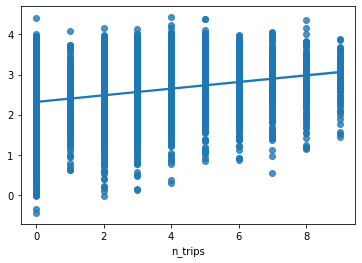

In [85]:
sns.regplot(y_test,LR_pred) #plotting predictions 

In [86]:
#calculate VIF scores to detect multicolinearity 

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = x_train.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train.values, i)
                          for i in range(len(x_train.columns))]
  
print(vif_data)

                            feature        VIF
0                           NUMADLT  29.419768
1                        YOUNGCHILD  20.265531
2                          WRKCOUNT  60.693040
3                            EDUC_1   6.450828
4                            EDUC_2  21.028886
..                              ...        ...
103  YOUNGCHILD_ratio_more_than_0.5        inf
104                WRKCOUNT_ratio_0        inf
105                WRKCOUNT_ratio_1        inf
106    WRKCOUNT_ratio_less_than_0.5        inf
107    WRKCOUNT_ratio_more_than_0.5        inf

[108 rows x 2 columns]


In [87]:
vif_data.sort_values(by = 'VIF', ascending = False)

,feature,VIF
107,WRKCOUNT_ratio_more_than_0.5,inf
81,LIF_CYC_10,inf
83,LIF_CYC_3,inf
84,LIF_CYC_4,inf
85,LIF_CYC_5,inf
...,...,...
54,HHFAMINC_3,2.862544
53,HHFAMINC_2,1.930102
50,HHFAMINC_1,1.737317
11,R_RACE_4,1.567955


In [88]:
# counting number of infinity features 

vif_data_inf = np.isinf(vif_data['VIF']).values.sum()
print("It contains " + str(vif_data_inf) + " infinite values")

It contains 66 infinite values


In [89]:
#cross validation to see if it will improve results 

folds = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = model_selection.cross_val_score(LRmodel, x_train, y_train, scoring='r2', cv=folds)

print('\nR2 score:',scores)


R2 score: [-4.47263518e+21  7.40029270e-02  7.74287806e-02  7.72583935e-02
  6.87242722e-02]


In [90]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
scores

array([-4472635181583187836928.000000, 0.074003, 0.077429, 0.077258,
       0.068724])

In [91]:
start_time = time.time()
from sklearn.feature_selection import RFE


#specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1,133))}]


# perform grid search

rfe = RFE(LRmodel)             

# 3.2 call GridSearchCV()
model_cv = model_selection.GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 10,
                        return_train_score=True)      

# fit the model
model_cv.fit(x_train, y_train)   

print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))

Fitting 5 folds for each of 132 candidates, totalling 660 fits
[CV 1/5; 1/132] START n_features_to_select=1....................................
[CV 1/5; 1/132] END n_features_to_select=1;, score=(train=0.001, test=0.001) total time=   3.1s
[CV 2/5; 1/132] START n_features_to_select=1....................................
[CV 2/5; 1/132] END n_features_to_select=1;, score=(train=0.000, test=0.000) total time=   3.3s
[CV 3/5; 1/132] START n_features_to_select=1....................................
[CV 3/5; 1/132] END n_features_to_select=1;, score=(train=0.001, test=-0.002) total time=   3.0s
[CV 4/5; 1/132] START n_features_to_select=1....................................
[CV 4/5; 1/132] END n_features_to_select=1;, score=(train=0.003, test=0.002) total time=   2.6s
[CV 5/5; 1/132] START n_features_to_select=1....................................
[CV 5/5; 1/132] END n_features_to_select=1;, score=(train=0.000, test=-0.000) total time=   3.7s
[CV 1/5; 2/132] START n_features_to_select=2......

[CV 2/5; 10/132] END n_features_to_select=10;, score=(train=0.005, test=0.004) total time=   3.0s
[CV 3/5; 10/132] START n_features_to_select=10..................................
[CV 3/5; 10/132] END n_features_to_select=10;, score=(train=0.008, test=0.004) total time=   2.9s
[CV 4/5; 10/132] START n_features_to_select=10..................................
[CV 4/5; 10/132] END n_features_to_select=10;, score=(train=0.006, test=0.005) total time=   3.0s
[CV 5/5; 10/132] START n_features_to_select=10..................................
[CV 5/5; 10/132] END n_features_to_select=10;, score=(train=0.005, test=0.003) total time=   2.8s
[CV 1/5; 11/132] START n_features_to_select=11..................................
[CV 1/5; 11/132] END n_features_to_select=11;, score=(train=0.004, test=-16050840511451968307200.000) total time=   2.9s
[CV 2/5; 11/132] START n_features_to_select=11..................................
[CV 2/5; 11/132] END n_features_to_select=11;, score=(train=0.005, test=0.004) tot

[CV 2/5; 19/132] END n_features_to_select=19;, score=(train=0.012, test=0.012) total time=   3.1s
[CV 3/5; 19/132] START n_features_to_select=19..................................
[CV 3/5; 19/132] END n_features_to_select=19;, score=(train=0.012, test=0.010) total time=   3.0s
[CV 4/5; 19/132] START n_features_to_select=19..................................
[CV 4/5; 19/132] END n_features_to_select=19;, score=(train=0.008, test=0.008) total time=   3.0s
[CV 5/5; 19/132] START n_features_to_select=19..................................
[CV 5/5; 19/132] END n_features_to_select=19;, score=(train=0.008, test=0.006) total time=   2.6s
[CV 1/5; 20/132] START n_features_to_select=20..................................
[CV 1/5; 20/132] END n_features_to_select=20;, score=(train=0.014, test=-6271350063910537396224.000) total time=   2.7s
[CV 2/5; 20/132] START n_features_to_select=20..................................
[CV 2/5; 20/132] END n_features_to_select=20;, score=(train=0.012, test=0.012) tota

[CV 2/5; 28/132] END n_features_to_select=28;, score=(train=0.022, test=0.018) total time=   2.7s
[CV 3/5; 28/132] START n_features_to_select=28..................................
[CV 3/5; 28/132] END n_features_to_select=28;, score=(train=0.013, test=0.013) total time=   2.8s
[CV 4/5; 28/132] START n_features_to_select=28..................................
[CV 4/5; 28/132] END n_features_to_select=28;, score=(train=0.015, test=0.011) total time=   2.7s
[CV 5/5; 28/132] START n_features_to_select=28..................................
[CV 5/5; 28/132] END n_features_to_select=28;, score=(train=0.018, test=0.011) total time=   2.6s
[CV 1/5; 29/132] START n_features_to_select=29..................................
[CV 1/5; 29/132] END n_features_to_select=29;, score=(train=0.025, test=-6934538478665295986688.000) total time=   2.8s
[CV 2/5; 29/132] START n_features_to_select=29..................................
[CV 2/5; 29/132] END n_features_to_select=29;, score=(train=0.022, test=0.019) tota

[CV 2/5; 37/132] END n_features_to_select=37;, score=(train=0.026, test=0.024) total time=   2.6s
[CV 3/5; 37/132] START n_features_to_select=37..................................
[CV 3/5; 37/132] END n_features_to_select=37;, score=(train=0.025, test=0.032) total time=   2.6s
[CV 4/5; 37/132] START n_features_to_select=37..................................
[CV 4/5; 37/132] END n_features_to_select=37;, score=(train=0.024, test=0.020) total time=   2.5s
[CV 5/5; 37/132] START n_features_to_select=37..................................
[CV 5/5; 37/132] END n_features_to_select=37;, score=(train=0.029, test=0.020) total time=   2.4s
[CV 1/5; 38/132] START n_features_to_select=38..................................
[CV 1/5; 38/132] END n_features_to_select=38;, score=(train=0.032, test=-7974211028481338245120.000) total time=   2.9s
[CV 2/5; 38/132] START n_features_to_select=38..................................
[CV 2/5; 38/132] END n_features_to_select=38;, score=(train=0.027, test=0.024) tota

[CV 2/5; 46/132] END n_features_to_select=46;, score=(train=0.030, test=0.026) total time=   2.6s
[CV 3/5; 46/132] START n_features_to_select=46..................................
[CV 3/5; 46/132] END n_features_to_select=46;, score=(train=0.038, test=0.041) total time=   2.6s
[CV 4/5; 46/132] START n_features_to_select=46..................................
[CV 4/5; 46/132] END n_features_to_select=46;, score=(train=0.030, test=0.025) total time=   2.6s
[CV 5/5; 46/132] START n_features_to_select=46..................................
[CV 5/5; 46/132] END n_features_to_select=46;, score=(train=0.030, test=0.021) total time=   2.7s
[CV 1/5; 47/132] START n_features_to_select=47..................................
[CV 1/5; 47/132] END n_features_to_select=47;, score=(train=0.037, test=-19850947542886412976128.000) total time=   2.7s
[CV 2/5; 47/132] START n_features_to_select=47..................................
[CV 2/5; 47/132] END n_features_to_select=47;, score=(train=0.031, test=0.025) tot

[CV 2/5; 55/132] END n_features_to_select=55;, score=(train=0.043, test=0.033) total time=   2.4s
[CV 3/5; 55/132] START n_features_to_select=55..................................
[CV 3/5; 55/132] END n_features_to_select=55;, score=(train=0.042, test=0.042) total time=   2.2s
[CV 4/5; 55/132] START n_features_to_select=55..................................
[CV 4/5; 55/132] END n_features_to_select=55;, score=(train=0.044, test=0.041) total time=   2.2s
[CV 5/5; 55/132] START n_features_to_select=55..................................
[CV 5/5; 55/132] END n_features_to_select=55;, score=(train=0.032, test=0.022) total time=   2.2s
[CV 1/5; 56/132] START n_features_to_select=56..................................
[CV 1/5; 56/132] END n_features_to_select=56;, score=(train=0.041, test=-2547339394490970406912.000) total time=   2.2s
[CV 2/5; 56/132] START n_features_to_select=56..................................
[CV 2/5; 56/132] END n_features_to_select=56;, score=(train=0.043, test=0.033) tota

[CV 2/5; 64/132] END n_features_to_select=64;, score=(train=0.048, test=0.030) total time=   2.0s
[CV 3/5; 64/132] START n_features_to_select=64..................................
[CV 3/5; 64/132] END n_features_to_select=64;, score=(train=0.044, test=0.047) total time=   2.1s
[CV 4/5; 64/132] START n_features_to_select=64..................................
[CV 4/5; 64/132] END n_features_to_select=64;, score=(train=0.046, test=0.042) total time=   1.9s
[CV 5/5; 64/132] START n_features_to_select=64..................................
[CV 5/5; 64/132] END n_features_to_select=64;, score=(train=0.045, test=0.041) total time=   2.0s
[CV 1/5; 65/132] START n_features_to_select=65..................................
[CV 1/5; 65/132] END n_features_to_select=65;, score=(train=0.045, test=-357480761631240224768.000) total time=   1.9s
[CV 2/5; 65/132] START n_features_to_select=65..................................
[CV 2/5; 65/132] END n_features_to_select=65;, score=(train=0.048, test=0.030) total

[CV 2/5; 73/132] END n_features_to_select=73;, score=(train=0.064, test=0.049) total time=   1.7s
[CV 3/5; 73/132] START n_features_to_select=73..................................
[CV 3/5; 73/132] END n_features_to_select=73;, score=(train=0.062, test=0.057) total time=   2.2s
[CV 4/5; 73/132] START n_features_to_select=73..................................
[CV 4/5; 73/132] END n_features_to_select=73;, score=(train=0.057, test=0.049) total time=   2.2s
[CV 5/5; 73/132] START n_features_to_select=73..................................
[CV 5/5; 73/132] END n_features_to_select=73;, score=(train=0.068, test=0.060) total time=   1.8s
[CV 1/5; 74/132] START n_features_to_select=74..................................
[CV 1/5; 74/132] END n_features_to_select=74;, score=(train=0.062, test=-296213115089222784.000) total time=   2.0s
[CV 2/5; 74/132] START n_features_to_select=74..................................
[CV 2/5; 74/132] END n_features_to_select=74;, score=(train=0.068, test=0.054) total ti

[CV 2/5; 82/132] END n_features_to_select=82;, score=(train=0.080, test=0.067) total time=   1.3s
[CV 3/5; 82/132] START n_features_to_select=82..................................
[CV 3/5; 82/132] END n_features_to_select=82;, score=(train=0.065, test=0.059) total time=   1.4s
[CV 4/5; 82/132] START n_features_to_select=82..................................
[CV 4/5; 82/132] END n_features_to_select=82;, score=(train=0.071, test=0.066) total time=   1.5s
[CV 5/5; 82/132] START n_features_to_select=82..................................
[CV 5/5; 82/132] END n_features_to_select=82;, score=(train=0.076, test=0.064) total time=   1.4s
[CV 1/5; 83/132] START n_features_to_select=83..................................
[CV 1/5; 83/132] END n_features_to_select=83;, score=(train=0.069, test=-443791987501396.562) total time=   1.5s
[CV 2/5; 83/132] START n_features_to_select=83..................................
[CV 2/5; 83/132] END n_features_to_select=83;, score=(train=0.080, test=0.067) total time=

[CV 2/5; 91/132] END n_features_to_select=91;, score=(train=0.083, test=0.072) total time=   1.0s
[CV 3/5; 91/132] START n_features_to_select=91..................................
[CV 3/5; 91/132] END n_features_to_select=91;, score=(train=0.081, test=0.076) total time=   1.0s
[CV 4/5; 91/132] START n_features_to_select=91..................................
[CV 4/5; 91/132] END n_features_to_select=91;, score=(train=0.081, test=0.076) total time=   0.8s
[CV 5/5; 91/132] START n_features_to_select=91..................................
[CV 5/5; 91/132] END n_features_to_select=91;, score=(train=0.084, test=0.068) total time=   1.0s
[CV 1/5; 92/132] START n_features_to_select=92..................................
[CV 1/5; 92/132] END n_features_to_select=92;, score=(train=0.082, test=-17973526633327431680.000) total time=   0.8s
[CV 2/5; 92/132] START n_features_to_select=92..................................
[CV 2/5; 92/132] END n_features_to_select=92;, score=(train=0.084, test=0.072) total 

[CV 2/5; 100/132] END n_features_to_select=100;, score=(train=0.084, test=0.073) total time=   0.5s
[CV 3/5; 100/132] START n_features_to_select=100................................
[CV 3/5; 100/132] END n_features_to_select=100;, score=(train=0.079, test=0.072) total time=   0.5s
[CV 4/5; 100/132] START n_features_to_select=100................................
[CV 4/5; 100/132] END n_features_to_select=100;, score=(train=0.083, test=0.077) total time=   0.6s
[CV 5/5; 100/132] START n_features_to_select=100................................
[CV 5/5; 100/132] END n_features_to_select=100;, score=(train=0.085, test=0.068) total time=   0.5s
[CV 1/5; 101/132] START n_features_to_select=101................................
[CV 1/5; 101/132] END n_features_to_select=101;, score=(train=0.083, test=-1957281903554405120.000) total time=   0.4s
[CV 2/5; 101/132] START n_features_to_select=101................................
[CV 2/5; 101/132] END n_features_to_select=101;, score=(train=0.084, test=0.

[CV 2/5; 109/132] END n_features_to_select=109;, score=(train=0.085, test=0.074) total time=   0.0s
[CV 3/5; 109/132] START n_features_to_select=109................................
[CV 3/5; 109/132] END n_features_to_select=109;, score=(train=0.084, test=0.077) total time=   0.0s
[CV 4/5; 109/132] START n_features_to_select=109................................
[CV 4/5; 109/132] END n_features_to_select=109;, score=(train=0.084, test=0.077) total time=   0.0s
[CV 5/5; 109/132] START n_features_to_select=109................................
[CV 5/5; 109/132] END n_features_to_select=109;, score=(train=0.086, test=0.069) total time=   0.0s
[CV 1/5; 110/132] START n_features_to_select=110................................
[CV 1/5; 110/132] END n_features_to_select=110;, score=(train=0.083, test=-4472635181583187836928.000) total time=   0.0s
[CV 2/5; 110/132] START n_features_to_select=110................................
[CV 2/5; 110/132] END n_features_to_select=110;, score=(train=0.085, test

[CV 3/5; 118/132] END n_features_to_select=118;, score=(train=0.084, test=0.077) total time=   0.0s
[CV 4/5; 118/132] START n_features_to_select=118................................
[CV 4/5; 118/132] END n_features_to_select=118;, score=(train=0.084, test=0.077) total time=   0.0s
[CV 5/5; 118/132] START n_features_to_select=118................................
[CV 5/5; 118/132] END n_features_to_select=118;, score=(train=0.086, test=0.069) total time=   0.0s
[CV 1/5; 119/132] START n_features_to_select=119................................
[CV 1/5; 119/132] END n_features_to_select=119;, score=(train=0.083, test=-4472635181583187836928.000) total time=   0.0s
[CV 2/5; 119/132] START n_features_to_select=119................................
[CV 2/5; 119/132] END n_features_to_select=119;, score=(train=0.085, test=0.074) total time=   0.0s
[CV 3/5; 119/132] START n_features_to_select=119................................
[CV 3/5; 119/132] END n_features_to_select=119;, score=(train=0.084, test

[CV 4/5; 127/132] END n_features_to_select=127;, score=(train=0.084, test=0.077) total time=   0.0s
[CV 5/5; 127/132] START n_features_to_select=127................................
[CV 5/5; 127/132] END n_features_to_select=127;, score=(train=0.086, test=0.069) total time=   0.0s
[CV 1/5; 128/132] START n_features_to_select=128................................
[CV 1/5; 128/132] END n_features_to_select=128;, score=(train=0.083, test=-4472635181583187836928.000) total time=   0.0s
[CV 2/5; 128/132] START n_features_to_select=128................................
[CV 2/5; 128/132] END n_features_to_select=128;, score=(train=0.085, test=0.074) total time=   0.0s
[CV 3/5; 128/132] START n_features_to_select=128................................
[CV 3/5; 128/132] END n_features_to_select=128;, score=(train=0.084, test=0.077) total time=   0.0s
[CV 4/5; 128/132] START n_features_to_select=128................................
[CV 4/5; 128/132] END n_features_to_select=128;, score=(train=0.084, test

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, 30, ...]}],
             return_train_score=True, scoring='r2', verbose=10)

In [92]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.227801,0.351007,0.006299,0.002160,1,{'n_features_to_select': 1},1.299240e-03,0.000089,-0.001551,0.002491,...,4.509012e-04,1.363570e-03,8,0.000610,0.000316,0.001162,0.002670,0.000343,0.001020,0.000879
1,3.329803,0.848063,0.008197,0.002293,2,{'n_features_to_select': 2},1.882429e-03,0.000587,0.002083,0.003611,...,1.836872e-03,1.042985e-03,7,0.001294,0.000600,0.003542,0.003569,0.001536,0.002108,0.001221
2,3.052798,0.145953,0.007401,0.002578,3,{'n_features_to_select': 3},3.798272e-03,-0.000187,0.003421,0.003976,...,2.408673e-03,1.675516e-03,5,0.002622,0.000981,0.005226,0.003740,0.001536,0.002821,0.001530
3,3.147403,0.235413,0.005196,0.000400,4,{'n_features_to_select': 4},3.372466e-03,-0.000112,0.004099,0.003550,...,2.390404e-03,1.631355e-03,6,0.003331,0.000978,0.006254,0.003950,0.001528,0.003208,0.001878
4,3.091194,0.200567,0.005699,0.000928,5,{'n_features_to_select': 5},3.372836e-03,0.001403,0.004130,0.004207,...,2.835593e-03,1.344122e-03,3,0.003330,0.003941,0.007271,0.004066,0.001532,0.004028,0.001857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,0.083691,0.007359,0.008702,0.001074,128,{'n_features_to_select': 128},-4.472635e+21,0.074003,0.077429,0.077258,...,-8.945270e+20,1.789054e+21,65,0.083387,0.084798,0.083820,0.084051,0.086076,0.084426,0.000943
128,0.090701,0.005218,0.009699,0.003613,129,{'n_features_to_select': 129},-4.472635e+21,0.074003,0.077429,0.077258,...,-8.945270e+20,1.789054e+21,65,0.083387,0.084798,0.083820,0.084051,0.086076,0.084426,0.000943
129,0.095099,0.019449,0.008300,0.000927,130,{'n_features_to_select': 130},-4.472635e+21,0.074003,0.077429,0.077258,...,-8.945270e+20,1.789054e+21,65,0.083387,0.084798,0.083820,0.084051,0.086076,0.084426,0.000943
130,0.092304,0.012993,0.009100,0.002887,131,{'n_features_to_select': 131},-4.472635e+21,0.074003,0.077429,0.077258,...,-8.945270e+20,1.789054e+21,65,0.083387,0.084798,0.083820,0.084051,0.086076,0.084426,0.000943


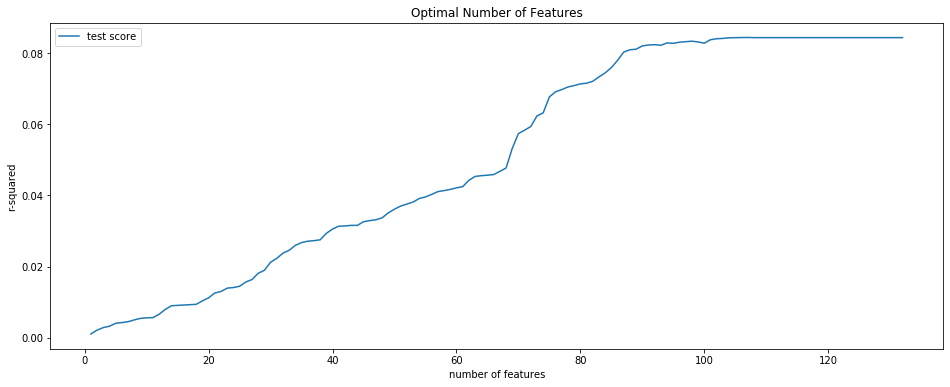

In [93]:
# plotting cv results
plt.figure(figsize=(16,6))

#plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

#### 4.1.1.2 Linear Regression - Regularisation

**Lasso Regularisation**

In [94]:
start_time = time.time()
alpha = [0.0001, 0.001, 0.005, 0.01]

for i in range(4):
    #build lasso regressor model here
    lasso = linear_model.Lasso(alpha=alpha[i])
    lasso.fit(x_train, y_train) #fit a lasso regression on the training data
    y_predlasso = lasso.predict(x_test) #use this model to predict the test data
    lasso_mse = metrics.mean_squared_error(y_test, y_predlasso) #calculate the test MSE
    lasso_rmse = metrics.mean_squared_error(y_test, y_predlasso,squared = False) #calculate the test RMSE
    msemanual = np.mean((y_predlasso-y_test)**2) #calculate mse manually to cross validate
    lasso_cplxy = (np.sum(abs(lasso.coef_))) #calculate l1norm / model complexity
    
    print('-' * 32)
    print('lasso with alpha', alpha[i])
    print('-' * 32)
    print('\nTrain score:', round(lasso.score(x_train, y_train), 3)) #compute train R^2 score
    print('Test score:', round(lasso.score(x_test, y_test), 3)) #compute test R^2 score
    print(list(map(lambda x: round(x, 3), lasso.coef_))) #list out the coef values 
    print('-' * 32)
    print('MSE on test set:', lasso_mse) #compute MSE results
    print('Manual MSE on test set:',msemanual) #compute MSE results
    print('RMSE on test set:', lasso_rmse) #compute RMSE results
    print('model complexity:', lasso_cplxy) #compute L1 NOMR score
    print('regularized cost:', lasso_mse + alpha[i] * lasso_cplxy) #compute regularised cost function scores
    print('\n')
print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))   

--------------------------------
lasso with alpha 0.0001
--------------------------------

Train score: 0.083
Test score: 0.08
[-2.044, 0.229, 1.169, -0.381, -0.415, -0.16, 0.0, 0.073, -0.181, -0.349, -0.542, -0.081, -0.252, -0.38, -0.545, -0.0, 0.329, -0.09, 0.186, -0.0, 0.307, 0.108, 0.164, -0.333, 0.095, 0.532, 1.421, 0.375, -0.355, -0.182, 0.006, 0.083, -0.045, 0.121, -0.0, 0.026, -0.012, -0.0, 0.0, 0.0, -0.065, 0.026, 0.447, 0.176, -0.012, -0.053, -0.091, 0.054, 0.0, -0.019, -0.258, 0.194, 0.276, -0.063, -0.028, 0.124, 0.198, 0.222, 0.198, 0.225, 0.345, -0.002, 0.155, 0.02, -0.062, 0.0, 0.233, -0.017, 0.003, -0.0, -0.001, -0.261, 0.0, 0.015, -0.0, 0.024, -0.242, -0.147, 0.0, -0.0, 0.0, -0.037, -0.188, 0.326, 0.104, 0.131, -0.047, -0.0, -0.16, 0.195, -0.379, -0.2, -0.236, -0.125, 0.013, 0.191, 0.005, 0.018, 0.416, -0.285, 0.0, 0.289, -0.0, -0.272, 0.706, -0.449, 0.35, -0.0]
--------------------------------
MSE on test set: 5.072072011659601
Manual MSE on test set: 5.072072011659594

**Ridge Regularisation**

In [95]:
start_time = time.time()
ridgealpha = [0.001, 0.01, 0.1, 1]

for i in range(4):
    #build ridge regressor here
    ridge = linear_model.Ridge(alpha=ridgealpha[i])
    ridge.fit(x_train, y_train) #fit a ridge regression on the training data
    y_pred_ridge = ridge.predict(x_test) #use this model to predict the test data
    ridge_mse = metrics.mean_squared_error(y_test, y_pred_ridge) #calculate the test mse
    ridge_rmse = metrics.mean_squared_error(y_test, y_pred_ridge,squared = False) #calculate the test rmse
    ridge_cplxy = (np.linalg.norm(ridge.coef_)) #calculate l2norm / model complexity
    
    print('-' * 32)
    print('ridge with alpha', ridgealpha[i])
    print('-' * 32)
    print('\nTrain score:', round(ridge.score(x_train, y_train), 3))
    print('Test score:', round(ridge.score(x_test, y_test), 3))
    print(list(map(lambda x: round(x, 3), ridge.coef_)))
    print('-' * 32)
    print('MSE on test set:', ridge_mse)
    print('RMSE on test set:', ridge_rmse)
    print('model complexity:', ridge_cplxy)
    print('regularized cost:', ridge_mse + ridgealpha[i] * ridge_cplxy)
    print('\n')
print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))

--------------------------------
ridge with alpha 0.001
--------------------------------

Train score: 0.084
Test score: 0.08
[-2.174, 0.574, 1.286, -0.412, -0.446, -0.191, -0.032, 0.04, -0.336, -0.505, -0.7, -0.274, -0.589, -0.538, -0.702, 0.147, 0.476, -1.609, -1.33, 0.363, 0.671, 1.262, 1.318, 0.818, 1.248, 1.882, 1.488, 0.442, -0.303, -0.129, 0.06, 0.136, 0.009, 0.175, 0.052, 0.036, -0.025, 0.008, -0.018, 1.015, 0.95, 1.056, 0.25, 0.061, -0.138, -0.173, -0.078, 0.068, 0.016, -0.005, -0.243, 0.213, 0.294, -0.048, -0.013, 0.142, 0.215, 0.241, 0.216, 0.244, 0.364, -0.025, 0.043, 0.036, -0.054, -0.06, 0.174, -0.078, 0.043, -0.025, -0.054, -0.066, 0.066, 0.085, 0.069, 0.095, -0.173, -0.077, 0.066, -0.066, 0.027, -0.093, -0.242, 0.298, 0.069, 0.082, -0.098, -0.056, -0.21, 0.223, -0.296, -0.119, -0.154, -0.04, 0.1, 0.311, 0.092, 0.106, 0.42, -0.369, -0.051, 0.387, -0.008, -0.379, 0.606, -0.665, 0.224, -0.164]
--------------------------------
MSE on test set: 5.0731338372460995
RMSE on tes

### 4.1.1.3. Principal Component Regression

In [96]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn import model_selection


In [97]:
pca = PCA()
x_reduced = pca.fit_transform(scale(x_train))


In [98]:
pd.DataFrame(pca.components_.T).loc[:4,:5]
#pd.DataFrame(pca.components_.T)

,0,1,2,3,4,5
0,-0.270686,-0.196228,-0.010032,-0.019760,0.000933,0.035803
1,0.173591,0.137749,-0.041017,0.100945,-0.024988,0.278908
2,0.007901,-0.087736,-0.362184,0.014901,-0.014313,-0.034608
3,0.061499,0.056848,0.072702,-0.028107,0.002661,-0.124340
4,-0.070963,0.012285,0.058168,0.001688,0.020390,0.034402


In [99]:
# 10-fold CV, with shuffle
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=100) 

pcascores = model_selection.cross_val_score(LRmodel, x_reduced, y_train, scoring='r2', cv=kf_10)

print('\nR2 score:',pcascores)


R2 score: [0.072635 -427590697163616026624.000000 0.080112 0.070442 0.072998
 0.084027 0.074034 0.083722 0.078263 0.059706]


In [100]:
#specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1,109))}]
   

# GridSearchCV()
pcamodel_cv = model_selection.GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = kf_10, 
                        verbose = 10,
                        return_train_score=True)      

# fit the model
pcamodel_cv.fit(x_reduced, y_train)              

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[CV 1/10; 1/108] START n_features_to_select=1...................................
[CV 1/10; 1/108] END n_features_to_select=1;, score=(train=0.000, test=-0.000) total time=   4.0s
[CV 2/10; 1/108] START n_features_to_select=1...................................
[CV 2/10; 1/108] END n_features_to_select=1;, score=(train=0.000, test=-0.001) total time=   3.9s
[CV 3/10; 1/108] START n_features_to_select=1...................................
[CV 3/10; 1/108] END n_features_to_select=1;, score=(train=0.000, test=-0.000) total time=   3.9s
[CV 4/10; 1/108] START n_features_to_select=1...................................
[CV 4/10; 1/108] END n_features_to_select=1;, score=(train=0.000, test=-0.000) total time=   3.9s
[CV 5/10; 1/108] START n_features_to_select=1...................................
[CV 5/10; 1/108] END n_features_to_select=1;, score=(train=0.000, test=-0.001) total time=   4.0s
[CV 6/10; 1/108] START n_features_to_sel

[CV 6/10; 5/108] END n_features_to_select=5;, score=(train=0.001, test=-0.002) total time=   3.9s
[CV 7/10; 5/108] START n_features_to_select=5...................................
[CV 7/10; 5/108] END n_features_to_select=5;, score=(train=0.000, test=-0.001) total time=   4.3s
[CV 8/10; 5/108] START n_features_to_select=5...................................
[CV 8/10; 5/108] END n_features_to_select=5;, score=(train=0.000, test=-0.000) total time=   4.0s
[CV 9/10; 5/108] START n_features_to_select=5...................................
[CV 9/10; 5/108] END n_features_to_select=5;, score=(train=0.000, test=-0.001) total time=   3.6s
[CV 10/10; 5/108] START n_features_to_select=5..................................
[CV 10/10; 5/108] END n_features_to_select=5;, score=(train=0.000, test=-0.001) total time=   3.7s
[CV 1/10; 6/108] START n_features_to_select=6...................................
[CV 1/10; 6/108] END n_features_to_select=6;, score=(train=0.000, test=-0.008) total time=   3.9s
[CV 2/

[CV 2/10; 10/108] END n_features_to_select=10;, score=(train=0.001, test=-0.002) total time=   3.5s
[CV 3/10; 10/108] START n_features_to_select=10.................................
[CV 3/10; 10/108] END n_features_to_select=10;, score=(train=0.001, test=-0.001) total time=   3.9s
[CV 4/10; 10/108] START n_features_to_select=10.................................
[CV 4/10; 10/108] END n_features_to_select=10;, score=(train=0.001, test=-0.016) total time=   3.7s
[CV 5/10; 10/108] START n_features_to_select=10.................................
[CV 5/10; 10/108] END n_features_to_select=10;, score=(train=0.000, test=-0.000) total time=   3.9s
[CV 6/10; 10/108] START n_features_to_select=10.................................
[CV 6/10; 10/108] END n_features_to_select=10;, score=(train=0.001, test=-0.002) total time=   3.6s
[CV 7/10; 10/108] START n_features_to_select=10.................................
[CV 7/10; 10/108] END n_features_to_select=10;, score=(train=0.001, test=-0.007) total time=   

[CV 8/10; 14/108] END n_features_to_select=14;, score=(train=0.001, test=-0.001) total time=   4.0s
[CV 9/10; 14/108] START n_features_to_select=14.................................
[CV 9/10; 14/108] END n_features_to_select=14;, score=(train=0.001, test=-0.002) total time=   3.7s
[CV 10/10; 14/108] START n_features_to_select=14................................
[CV 10/10; 14/108] END n_features_to_select=14;, score=(train=0.001, test=-0.000) total time=   3.7s
[CV 1/10; 15/108] START n_features_to_select=15.................................
[CV 1/10; 15/108] END n_features_to_select=15;, score=(train=0.001, test=-0.058) total time=   4.0s
[CV 2/10; 15/108] START n_features_to_select=15.................................
[CV 2/10; 15/108] END n_features_to_select=15;, score=(train=0.001, test=-0.002) total time=   4.5s
[CV 3/10; 15/108] START n_features_to_select=15.................................
[CV 3/10; 15/108] END n_features_to_select=15;, score=(train=0.001, test=-0.000) total time=  

[CV 4/10; 19/108] END n_features_to_select=19;, score=(train=0.001, test=-0.007) total time=   3.6s
[CV 5/10; 19/108] START n_features_to_select=19.................................
[CV 5/10; 19/108] END n_features_to_select=19;, score=(train=0.001, test=0.000) total time=   4.1s
[CV 6/10; 19/108] START n_features_to_select=19.................................
[CV 6/10; 19/108] END n_features_to_select=19;, score=(train=0.001, test=-0.002) total time=   4.0s
[CV 7/10; 19/108] START n_features_to_select=19.................................
[CV 7/10; 19/108] END n_features_to_select=19;, score=(train=0.001, test=-0.013) total time=   3.8s
[CV 8/10; 19/108] START n_features_to_select=19.................................
[CV 8/10; 19/108] END n_features_to_select=19;, score=(train=0.001, test=-0.001) total time=   4.3s
[CV 9/10; 19/108] START n_features_to_select=19.................................
[CV 9/10; 19/108] END n_features_to_select=19;, score=(train=0.001, test=-0.002) total time=   3

[CV 10/10; 23/108] END n_features_to_select=23;, score=(train=0.002, test=0.000) total time=   3.5s
[CV 1/10; 24/108] START n_features_to_select=24.................................
[CV 1/10; 24/108] END n_features_to_select=24;, score=(train=0.002, test=-0.078) total time=   3.5s
[CV 2/10; 24/108] START n_features_to_select=24.................................
[CV 2/10; 24/108] END n_features_to_select=24;, score=(train=0.022, test=-3.661) total time=   3.7s
[CV 3/10; 24/108] START n_features_to_select=24.................................
[CV 3/10; 24/108] END n_features_to_select=24;, score=(train=0.002, test=0.001) total time=   3.5s
[CV 4/10; 24/108] START n_features_to_select=24.................................
[CV 4/10; 24/108] END n_features_to_select=24;, score=(train=0.002, test=-0.008) total time=   3.3s
[CV 5/10; 24/108] START n_features_to_select=24.................................
[CV 5/10; 24/108] END n_features_to_select=24;, score=(train=0.002, test=0.001) total time=   3.

[CV 6/10; 28/108] END n_features_to_select=28;, score=(train=0.024, test=0.016) total time=   3.4s
[CV 7/10; 28/108] START n_features_to_select=28.................................
[CV 7/10; 28/108] END n_features_to_select=28;, score=(train=0.024, test=0.019) total time=   3.4s
[CV 8/10; 28/108] START n_features_to_select=28.................................
[CV 8/10; 28/108] END n_features_to_select=28;, score=(train=0.030, test=0.030) total time=   3.7s
[CV 9/10; 28/108] START n_features_to_select=28.................................
[CV 9/10; 28/108] END n_features_to_select=28;, score=(train=0.035, test=0.030) total time=   4.1s
[CV 10/10; 28/108] START n_features_to_select=28................................
[CV 10/10; 28/108] END n_features_to_select=28;, score=(train=0.031, test=0.016) total time=   3.9s
[CV 1/10; 29/108] START n_features_to_select=29.................................
[CV 1/10; 29/108] END n_features_to_select=29;, score=(train=0.030, test=0.031) total time=   3.8s


[CV 2/10; 33/108] END n_features_to_select=33;, score=(train=0.042, test=0.033) total time=   3.3s
[CV 3/10; 33/108] START n_features_to_select=33.................................
[CV 3/10; 33/108] END n_features_to_select=33;, score=(train=0.041, test=0.045) total time=   3.4s
[CV 4/10; 33/108] START n_features_to_select=33.................................
[CV 4/10; 33/108] END n_features_to_select=33;, score=(train=0.036, test=0.029) total time=   3.9s
[CV 5/10; 33/108] START n_features_to_select=33.................................
[CV 5/10; 33/108] END n_features_to_select=33;, score=(train=0.037, test=0.031) total time=   4.6s
[CV 6/10; 33/108] START n_features_to_select=33.................................
[CV 6/10; 33/108] END n_features_to_select=33;, score=(train=0.049, test=0.042) total time=   4.2s
[CV 7/10; 33/108] START n_features_to_select=33.................................
[CV 7/10; 33/108] END n_features_to_select=33;, score=(train=0.036, test=0.026) total time=   3.8s
[

[CV 8/10; 37/108] END n_features_to_select=37;, score=(train=0.056, test=0.058) total time=   3.3s
[CV 9/10; 37/108] START n_features_to_select=37.................................
[CV 9/10; 37/108] END n_features_to_select=37;, score=(train=0.060, test=0.054) total time=   3.1s
[CV 10/10; 37/108] START n_features_to_select=37................................
[CV 10/10; 37/108] END n_features_to_select=37;, score=(train=0.064, test=0.041) total time=   3.3s
[CV 1/10; 38/108] START n_features_to_select=38.................................
[CV 1/10; 38/108] END n_features_to_select=38;, score=(train=0.051, test=0.054) total time=   3.4s
[CV 2/10; 38/108] START n_features_to_select=38.................................
[CV 2/10; 38/108] END n_features_to_select=38;, score=(train=0.058, test=-1.075) total time=   3.2s
[CV 3/10; 38/108] START n_features_to_select=38.................................
[CV 3/10; 38/108] END n_features_to_select=38;, score=(train=0.050, test=0.051) total time=   3.3s

[CV 4/10; 42/108] END n_features_to_select=42;, score=(train=0.065, test=0.058) total time=   3.6s
[CV 5/10; 42/108] START n_features_to_select=42.................................
[CV 5/10; 42/108] END n_features_to_select=42;, score=(train=0.061, test=0.062) total time=   3.8s
[CV 6/10; 42/108] START n_features_to_select=42.................................
[CV 6/10; 42/108] END n_features_to_select=42;, score=(train=0.067, test=0.069) total time=   3.6s
[CV 7/10; 42/108] START n_features_to_select=42.................................
[CV 7/10; 42/108] END n_features_to_select=42;, score=(train=0.066, test=0.055) total time=   3.1s
[CV 8/10; 42/108] START n_features_to_select=42.................................
[CV 8/10; 42/108] END n_features_to_select=42;, score=(train=0.065, test=0.065) total time=   3.0s
[CV 9/10; 42/108] START n_features_to_select=42.................................
[CV 9/10; 42/108] END n_features_to_select=42;, score=(train=0.068, test=0.063) total time=   3.1s
[

[CV 10/10; 46/108] END n_features_to_select=46;, score=(train=0.069, test=0.047) total time=   3.1s
[CV 1/10; 47/108] START n_features_to_select=47.................................
[CV 1/10; 47/108] END n_features_to_select=47;, score=(train=0.070, test=0.066) total time=   3.1s
[CV 2/10; 47/108] START n_features_to_select=47.................................
[CV 2/10; 47/108] END n_features_to_select=47;, score=(train=0.068, test=-11.110) total time=   3.1s
[CV 3/10; 47/108] START n_features_to_select=47.................................
[CV 3/10; 47/108] END n_features_to_select=47;, score=(train=0.070, test=0.070) total time=   3.1s
[CV 4/10; 47/108] START n_features_to_select=47.................................
[CV 4/10; 47/108] END n_features_to_select=47;, score=(train=0.064, test=0.060) total time=   3.1s
[CV 5/10; 47/108] START n_features_to_select=47.................................
[CV 5/10; 47/108] END n_features_to_select=47;, score=(train=0.070, test=0.070) total time=   3.0

[CV 6/10; 51/108] END n_features_to_select=51;, score=(train=0.073, test=0.074) total time=   2.9s
[CV 7/10; 51/108] START n_features_to_select=51.................................
[CV 7/10; 51/108] END n_features_to_select=51;, score=(train=0.055, test=0.046) total time=   2.9s
[CV 8/10; 51/108] START n_features_to_select=51.................................
[CV 8/10; 51/108] END n_features_to_select=51;, score=(train=0.070, test=0.074) total time=   3.0s
[CV 9/10; 51/108] START n_features_to_select=51.................................
[CV 9/10; 51/108] END n_features_to_select=51;, score=(train=0.075, test=0.076) total time=   2.9s
[CV 10/10; 51/108] START n_features_to_select=51................................
[CV 10/10; 51/108] END n_features_to_select=51;, score=(train=0.067, test=0.045) total time=   2.9s
[CV 1/10; 52/108] START n_features_to_select=52.................................
[CV 1/10; 52/108] END n_features_to_select=52;, score=(train=0.073, test=0.068) total time=   2.8s


[CV 2/10; 56/108] END n_features_to_select=56;, score=(train=0.072, test=-26.386) total time=   2.9s
[CV 3/10; 56/108] START n_features_to_select=56.................................
[CV 3/10; 56/108] END n_features_to_select=56;, score=(train=0.076, test=0.073) total time=   2.7s
[CV 4/10; 56/108] START n_features_to_select=56.................................
[CV 4/10; 56/108] END n_features_to_select=56;, score=(train=0.071, test=0.060) total time=   2.7s
[CV 5/10; 56/108] START n_features_to_select=56.................................
[CV 5/10; 56/108] END n_features_to_select=56;, score=(train=0.078, test=0.071) total time=   2.9s
[CV 6/10; 56/108] START n_features_to_select=56.................................
[CV 6/10; 56/108] END n_features_to_select=56;, score=(train=0.075, test=0.073) total time=   2.8s
[CV 7/10; 56/108] START n_features_to_select=56.................................
[CV 7/10; 56/108] END n_features_to_select=56;, score=(train=0.067, test=0.061) total time=   2.9s

[CV 8/10; 60/108] END n_features_to_select=60;, score=(train=0.075, test=0.077) total time=   2.7s
[CV 9/10; 60/108] START n_features_to_select=60.................................
[CV 9/10; 60/108] END n_features_to_select=60;, score=(train=0.078, test=0.076) total time=   2.9s
[CV 10/10; 60/108] START n_features_to_select=60................................
[CV 10/10; 60/108] END n_features_to_select=60;, score=(train=0.078, test=0.048) total time=   2.6s
[CV 1/10; 61/108] START n_features_to_select=61.................................
[CV 1/10; 61/108] END n_features_to_select=61;, score=(train=0.079, test=0.069) total time=   2.5s
[CV 2/10; 61/108] START n_features_to_select=61.................................
[CV 2/10; 61/108] END n_features_to_select=61;, score=(train=0.073, test=-44.197) total time=   2.7s
[CV 3/10; 61/108] START n_features_to_select=61.................................
[CV 3/10; 61/108] END n_features_to_select=61;, score=(train=0.078, test=0.076) total time=   2.5

[CV 4/10; 65/108] END n_features_to_select=65;, score=(train=0.040, test=0.030) total time=   2.4s
[CV 5/10; 65/108] START n_features_to_select=65.................................
[CV 5/10; 65/108] END n_features_to_select=65;, score=(train=0.082, test=0.071) total time=   2.5s
[CV 6/10; 65/108] START n_features_to_select=65.................................
[CV 6/10; 65/108] END n_features_to_select=65;, score=(train=0.073, test=0.069) total time=   2.5s
[CV 7/10; 65/108] START n_features_to_select=65.................................
[CV 7/10; 65/108] END n_features_to_select=65;, score=(train=0.077, test=0.067) total time=   2.4s
[CV 8/10; 65/108] START n_features_to_select=65.................................
[CV 8/10; 65/108] END n_features_to_select=65;, score=(train=0.079, test=0.080) total time=   2.5s
[CV 9/10; 65/108] START n_features_to_select=65.................................
[CV 9/10; 65/108] END n_features_to_select=65;, score=(train=0.081, test=0.075) total time=   2.5s
[

[CV 10/10; 69/108] END n_features_to_select=69;, score=(train=0.084, test=0.059) total time=   2.3s
[CV 1/10; 70/108] START n_features_to_select=70.................................
[CV 1/10; 70/108] END n_features_to_select=70;, score=(train=0.082, test=0.072) total time=   2.4s
[CV 2/10; 70/108] START n_features_to_select=70.................................
[CV 2/10; 70/108] END n_features_to_select=70;, score=(train=0.075, test=-88.426) total time=   2.2s
[CV 3/10; 70/108] START n_features_to_select=70.................................
[CV 3/10; 70/108] END n_features_to_select=70;, score=(train=0.082, test=0.078) total time=   2.2s
[CV 4/10; 70/108] START n_features_to_select=70.................................
[CV 4/10; 70/108] END n_features_to_select=70;, score=(train=0.081, test=0.068) total time=   2.2s
[CV 5/10; 70/108] START n_features_to_select=70.................................
[CV 5/10; 70/108] END n_features_to_select=70;, score=(train=0.083, test=0.071) total time=   2.3

[CV 6/10; 74/108] END n_features_to_select=74;, score=(train=0.082, test=0.083) total time=   2.1s
[CV 7/10; 74/108] START n_features_to_select=74.................................
[CV 7/10; 74/108] END n_features_to_select=74;, score=(train=0.083, test=0.074) total time=   2.0s
[CV 8/10; 74/108] START n_features_to_select=74.................................
[CV 8/10; 74/108] END n_features_to_select=74;, score=(train=0.081, test=0.085) total time=   2.0s
[CV 9/10; 74/108] START n_features_to_select=74.................................
[CV 9/10; 74/108] END n_features_to_select=74;, score=(train=0.083, test=0.078) total time=   2.0s
[CV 10/10; 74/108] START n_features_to_select=74................................
[CV 10/10; 74/108] END n_features_to_select=74;, score=(train=0.085, test=0.060) total time=   2.0s
[CV 1/10; 75/108] START n_features_to_select=75.................................
[CV 1/10; 75/108] END n_features_to_select=75;, score=(train=0.082, test=0.070) total time=   1.9s


[CV 2/10; 79/108] END n_features_to_select=79;, score=(train=0.077, test=-310.460) total time=   2.0s
[CV 3/10; 79/108] START n_features_to_select=79.................................
[CV 3/10; 79/108] END n_features_to_select=79;, score=(train=0.083, test=0.079) total time=   1.9s
[CV 4/10; 79/108] START n_features_to_select=79.................................
[CV 4/10; 79/108] END n_features_to_select=79;, score=(train=0.084, test=0.070) total time=   1.9s
[CV 5/10; 79/108] START n_features_to_select=79.................................
[CV 5/10; 79/108] END n_features_to_select=79;, score=(train=0.083, test=0.072) total time=   1.8s
[CV 6/10; 79/108] START n_features_to_select=79.................................
[CV 6/10; 79/108] END n_features_to_select=79;, score=(train=0.083, test=0.083) total time=   1.8s
[CV 7/10; 79/108] START n_features_to_select=79.................................
[CV 7/10; 79/108] END n_features_to_select=79;, score=(train=0.082, test=0.075) total time=   1.8

[CV 8/10; 83/108] END n_features_to_select=83;, score=(train=0.082, test=0.085) total time=   1.6s
[CV 9/10; 83/108] START n_features_to_select=83.................................
[CV 9/10; 83/108] END n_features_to_select=83;, score=(train=0.084, test=0.078) total time=   1.5s
[CV 10/10; 83/108] START n_features_to_select=83................................
[CV 10/10; 83/108] END n_features_to_select=83;, score=(train=0.085, test=0.062) total time=   1.7s
[CV 1/10; 84/108] START n_features_to_select=84.................................
[CV 1/10; 84/108] END n_features_to_select=84;, score=(train=0.083, test=0.073) total time=   1.5s
[CV 2/10; 84/108] START n_features_to_select=84.................................
[CV 2/10; 84/108] END n_features_to_select=84;, score=(train=0.077, test=-539.576) total time=   1.5s
[CV 3/10; 84/108] START n_features_to_select=84.................................
[CV 3/10; 84/108] END n_features_to_select=84;, score=(train=0.083, test=0.080) total time=   1.

[CV 4/10; 88/108] END n_features_to_select=88;, score=(train=0.084, test=0.070) total time=   1.3s
[CV 5/10; 88/108] START n_features_to_select=88.................................
[CV 5/10; 88/108] END n_features_to_select=88;, score=(train=0.084, test=0.073) total time=   1.3s
[CV 6/10; 88/108] START n_features_to_select=88.................................
[CV 6/10; 88/108] END n_features_to_select=88;, score=(train=0.083, test=0.084) total time=   1.4s
[CV 7/10; 88/108] START n_features_to_select=88.................................
[CV 7/10; 88/108] END n_features_to_select=88;, score=(train=0.084, test=0.074) total time=   1.4s
[CV 8/10; 88/108] START n_features_to_select=88.................................
[CV 8/10; 88/108] END n_features_to_select=88;, score=(train=0.079, test=0.080) total time=   1.3s
[CV 9/10; 88/108] START n_features_to_select=88.................................
[CV 9/10; 88/108] END n_features_to_select=88;, score=(train=0.084, test=0.078) total time=   1.3s
[

[CV 10/10; 92/108] END n_features_to_select=92;, score=(train=0.082, test=0.057) total time=   1.2s
[CV 1/10; 93/108] START n_features_to_select=93.................................
[CV 1/10; 93/108] END n_features_to_select=93;, score=(train=0.084, test=0.070) total time=   1.0s
[CV 2/10; 93/108] START n_features_to_select=93.................................
[CV 2/10; 93/108] END n_features_to_select=93;, score=(train=0.079, test=-2208.456) total time=   1.1s
[CV 3/10; 93/108] START n_features_to_select=93.................................
[CV 3/10; 93/108] END n_features_to_select=93;, score=(train=0.084, test=0.080) total time=   1.0s
[CV 4/10; 93/108] START n_features_to_select=93.................................
[CV 4/10; 93/108] END n_features_to_select=93;, score=(train=0.084, test=0.071) total time=   1.1s
[CV 5/10; 93/108] START n_features_to_select=93.................................
[CV 5/10; 93/108] END n_features_to_select=93;, score=(train=0.084, test=0.073) total time=   0

[CV 6/10; 97/108] END n_features_to_select=97;, score=(train=0.083, test=0.084) total time=   0.8s
[CV 7/10; 97/108] START n_features_to_select=97.................................
[CV 7/10; 97/108] END n_features_to_select=97;, score=(train=0.084, test=0.073) total time=   0.8s
[CV 8/10; 97/108] START n_features_to_select=97.................................
[CV 8/10; 97/108] END n_features_to_select=97;, score=(train=0.083, test=0.085) total time=   0.8s
[CV 9/10; 97/108] START n_features_to_select=97.................................
[CV 9/10; 97/108] END n_features_to_select=97;, score=(train=0.084, test=0.078) total time=   0.8s
[CV 10/10; 97/108] START n_features_to_select=97................................
[CV 10/10; 97/108] END n_features_to_select=97;, score=(train=0.086, test=0.059) total time=   0.8s
[CV 1/10; 98/108] START n_features_to_select=98.................................
[CV 1/10; 98/108] END n_features_to_select=98;, score=(train=0.084, test=0.073) total time=   0.7s


[CV 2/10; 102/108] END n_features_to_select=102;, score=(train=0.079, test=-3170.457) total time=   0.5s
[CV 3/10; 102/108] START n_features_to_select=102...............................
[CV 3/10; 102/108] END n_features_to_select=102;, score=(train=0.084, test=0.080) total time=   0.4s
[CV 4/10; 102/108] START n_features_to_select=102...............................
[CV 4/10; 102/108] END n_features_to_select=102;, score=(train=0.084, test=0.071) total time=   0.4s
[CV 5/10; 102/108] START n_features_to_select=102...............................
[CV 5/10; 102/108] END n_features_to_select=102;, score=(train=0.084, test=0.073) total time=   0.4s
[CV 6/10; 102/108] START n_features_to_select=102...............................
[CV 6/10; 102/108] END n_features_to_select=102;, score=(train=0.083, test=0.084) total time=   0.4s
[CV 7/10; 102/108] START n_features_to_select=102...............................
[CV 7/10; 102/108] END n_features_to_select=102;, score=(train=0.084, test=0.074) tota

[CV 7/10; 106/108] END n_features_to_select=106;, score=(train=0.084, test=0.075) total time=   0.1s
[CV 8/10; 106/108] START n_features_to_select=106...............................
[CV 8/10; 106/108] END n_features_to_select=106;, score=(train=0.083, test=0.083) total time=   0.2s
[CV 9/10; 106/108] START n_features_to_select=106...............................
[CV 9/10; 106/108] END n_features_to_select=106;, score=(train=0.084, test=0.078) total time=   0.2s
[CV 10/10; 106/108] START n_features_to_select=106..............................
[CV 10/10; 106/108] END n_features_to_select=106;, score=(train=0.086, test=0.059) total time=   0.1s
[CV 1/10; 107/108] START n_features_to_select=107...............................
[CV 1/10; 107/108] END n_features_to_select=107;, score=(train=0.085, test=0.073) total time=   0.1s
[CV 2/10; 107/108] START n_features_to_select=107...............................
[CV 2/10; 107/108] END n_features_to_select=107;, score=(train=0.082, test=-63367.384) to

GridSearchCV(cv=KFold(n_splits=10, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, 30, ...]}],
             return_train_score=True, scoring='r2', verbose=10)

In [101]:
pcacv_results = pd.DataFrame(pcamodel_cv.cv_results_)
pcacv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,3.993350,0.118710,0.000949,0.000150,1,{'n_features_to_select': 1},-0.000481,-6.356160e-04,-0.000034,-0.000186,...,0.000122,0.000114,0.000077,0.000208,0.000129,0.000196,0.000093,0.000162,0.000137,0.000049
1,4.152799,0.295731,0.001500,0.000671,2,{'n_features_to_select': 2},-0.001108,-5.328675e-04,-0.000406,-0.000390,...,0.000216,0.000276,0.000144,0.000263,0.000310,0.000262,0.000284,0.000200,0.000239,0.000068
2,4.037204,0.199817,0.001300,0.000400,3,{'n_features_to_select': 3},-0.001029,-4.857828e-04,-0.000387,-0.000157,...,0.000355,0.000304,0.000166,0.000342,0.000328,0.000382,0.000301,0.000270,0.000292,0.000078
3,4.008750,0.170562,0.001749,0.000600,4,{'n_features_to_select': 4},-0.002038,-4.750894e-04,-0.000895,-0.000568,...,0.000431,0.000338,0.000247,0.000467,0.000356,0.000392,0.000349,0.000401,0.000360,0.000075
4,3.975400,0.180628,0.001449,0.000522,5,{'n_features_to_select': 5},-0.002529,-9.676187e-04,-0.000764,-0.000571,...,0.000441,0.000339,0.000304,0.000606,0.000415,0.000425,0.000424,0.000460,0.000413,0.000089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,0.390099,0.017983,0.003804,0.000680,104,{'n_features_to_select': 104},0.072491,-5.622758e+04,0.080254,0.070667,...,0.083775,0.084454,0.084354,0.083240,0.084346,0.083098,0.083863,0.085669,0.083912,0.000977
104,0.328750,0.011984,0.003500,0.000864,105,{'n_features_to_select': 105},0.072560,-7.239304e+04,0.080015,0.070702,...,0.083777,0.084497,0.084359,0.083246,0.084353,0.083108,0.083874,0.085904,0.083978,0.000957
105,0.254700,0.020870,0.003751,0.000749,106,{'n_features_to_select': 106},0.072567,-4.423519e+04,0.080054,0.070881,...,0.083784,0.084467,0.084327,0.083236,0.084322,0.082846,0.083877,0.085929,0.083967,0.000948
106,0.199296,0.018292,0.003852,0.001226,107,{'n_features_to_select': 107},0.072576,-6.336738e+04,0.080193,0.070615,...,0.083782,0.084467,0.084365,0.083228,0.084288,0.082857,0.083880,0.085927,0.083950,0.000977


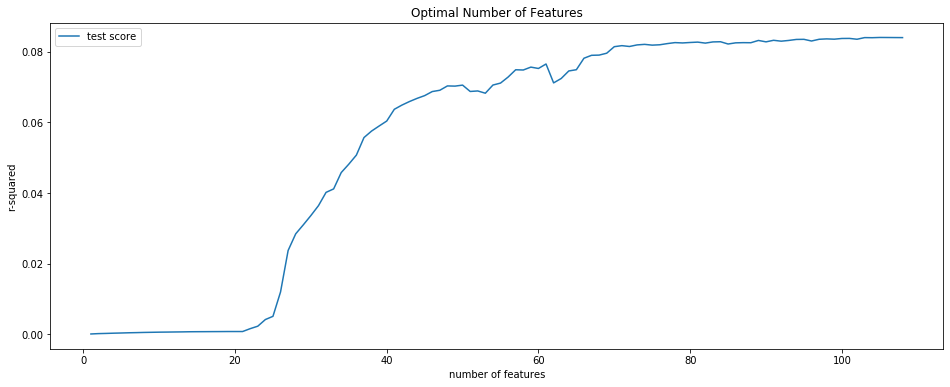

In [102]:
# plotting cv results
plt.figure(figsize=(16,6))

#plt.plot(cv_results["param_n_features_to_select"], pcacv_results["mean_test_score"])
plt.plot(pcacv_results["param_n_features_to_select"], pcacv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

Text(0, 0.5, 'cumulative explained variance')

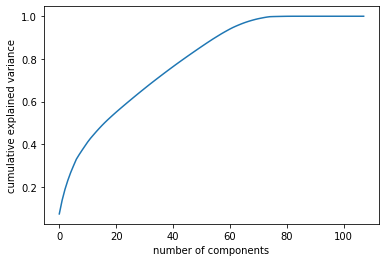

In [103]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

### 4.1.2. Ensemble Models

In [104]:
def evaluate_model(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions-test_labels)
    mse = metrics.mean_squared_error(test_labels,predictions)
    rmse = np.sqrt(mse)
    
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    rsquare = model.score(test_features,test_labels)
    importance = model.feature_importances_

    
    print('Model Preformance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%,'.format(accuracy))
    print('rmse',rmse)
    print('mse',mse)
    print('R square:', rsquare)
    
    print("__________")
    print("Top 5 Features")
    feature_dict = {}
    for i,v in enumerate(importance):
        #print('Feature %0d, Score: %.5f' % (i,v))
        feature_dict[i]=v
    feature_names = test_features.columns
    sorted_features = sorted(feature_dict.items(), key=lambda x: x[1], reverse=True)
    
    for i in sorted_features[:5]:
        print(feature_names[i[0]],i[1])
        
    plt.bar([x for x in range(len(importance))],importance)
    plt.show()
    
    
    
    return accuracy

### 4.1.2.1. Random Forest

In [105]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_features': [15, 17, 19],
    'oob_score': [True],
    'n_estimators': [900, 1200, 1500]
}
# Create a based model
rfgs = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfgs, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 3)
#wrapper_gs = RegressorChain(grid_search)
grid_search.fit(x_train, y_train)

#grid_search.fit(train_features, train_labels)
print(grid_search.best_params_)

print(grid_search.best_estimator_)
print(grid_search.best_score_)

y_pred_rfgs = grid_search.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfgs))
print("RMSE: %f" % (rmse))

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred_rfgs))
# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, y_pred_rfgs))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'bootstrap': True, 'max_features': 15, 'n_estimators': 1500, 'oob_score': True}
RandomForestRegressor(max_features=15, n_estimators=1500, oob_score=True)
0.0553575704910804
RMSE: 2.258326
Mean squared error: 5.10
R2 score: 0.07


Model Preformance
Average Error: 1.8217 degrees.
Accuracy = -inf%,
rmse 2.2583262495033107
mse 5.100037449195689
R square: 0.07499814740909283
__________
Top 5 Features
WRKCOUNT 0.028755349562309122
HHFAMINC_6 0.02183586756165286
HHVEHCNT_2 0.02122817390128447
TRAVDAY_7 0.019927756300579354
HHFAMINC_7 0.019450806818623764


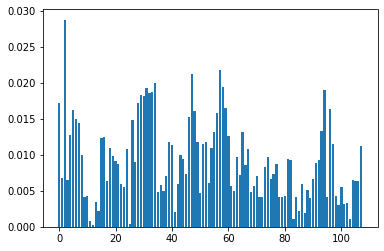

In [107]:
best_rf = grid_search.best_estimator_
rf_accuracy = evaluate_model(best_rf, x_test, y_test)


### 4.1.2.2. XGBoost

In [ ]:
# insert code of XGBoost

## SVM???

### 4.1.3. Neural Network

In [108]:
train_df = pd.concat([y_train,x_train], axis = 1)
test_df = pd.concat([y_test, x_train],axis =1)
test_df.rename(columns = {'HHSIZE_ above_3':'HHSIZE_above_3'} , inplace = True)

In [83]:
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
from keras.layers import Dropout

In [84]:
def create_model_deep(input_shape,learn_rate,dropout_rate, layers,kernel_reg): #name,my_feature_layer,dropout_rate, layers):
    model = tf.keras.models.Sequential()#name = name)
    model.add(tf.keras.Input(shape=(input_shape,)))
    #model.add(my_feature_layer)
    for index, layer in enumerate(layers):
        model.add(tf.keras.layers.Dense(units = layer,
                                        activation = 'relu',
                                        kernel_regularizer=kernel_reg,
                                        name=f'Hidden{index}'))
    model.add(Dropout(dropout_rate))  
    model.add(tf.keras.layers.Dense(units=1, name='Output'))  
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learn_rate),
                  loss="mean_squared_error",
                  metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [111]:
one_hot_labs = [c for c in train_df if train_df[c].dtype == 'uint8']
num_labs = ['tier diff','bay diff','quantity','pos diff']

In [112]:
feature_columns = []
for i in num_labs:
    i = tf.feature_column.numeric_column(i)
    feature_columns.append(i)
for k in one_hot_labs:
    k = tf.feature_column.numeric_column(k)
    feature_columns.append(k)
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [165]:
#use the same param_grid as earlier
import time
start_time = time.time()

input_shape = [x_train.shape[1]]
learn_rate = ((0.01),(0.1),(0.3))
batch_size = ((128,),(256,))
dropout_rate = ((0.1),(0),(0.2))
name = ['deep']
kernel_reg = ((tf.keras.regularizers.l2(0.04)),('glorot_uniform'))
layers = ((64,32,16,8),(64,16,8,4),(64,16),(100,64,32,16,8,4),(30,20,10,8))

 
param_grid = dict(input_shape = input_shape,
                  learn_rate = learn_rate,
                  dropout_rate = dropout_rate,
                  layers = layers,
                  kernel_reg = kernel_reg)

    
model_deep = KerasRegressor(build_fn = create_model_deep, epochs = 1000, batch_size = 256, verbose =2)
nn_grid = RandomizedSearchCV(estimator = model_deep, param_distributions = param_grid, n_jobs = -1, scoring='neg_mean_squared_error',verbose =5, cv = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 888))
nn_grid_result = nn_grid.fit(x_train, y_train)
best_nn = nn_grid.best_estimator_

print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Epoch 1/1000
100/100 - 0s - loss: 6.6993 - mean_squared_error: 5.4846
Epoch 2/1000
100/100 - 0s - loss: 5.6430 - mean_squared_error: 5.2424
Epoch 3/1000
100/100 - 0s - loss: 5.4697 - mean_squared_error: 5.2150
Epoch 4/1000
100/100 - 0s - loss: 5.4156 - mean_squared_error: 5.2091
Epoch 5/1000
100/100 - 0s - loss: 5.3854 - mean_squared_error: 5.2091
Epoch 6/1000
100/100 - 0s - loss: 5.3710 - mean_squared_error: 5.2055
Epoch 7/1000
100/100 - 0s - loss: 5.3435 - mean_squared_error: 5.1850
Epoch 8/1000
100/100 - 0s - loss: 5.3599 - mean_squared_error: 5.2071
Epoch 9/1000
100/100 - 0s - loss: 5.3350 - mean_squared_error: 5.1870
Epoch 10/1000
100/100 - 0s - loss: 5.3460 - mean_squared_error: 5.1986
Epoch 11/1000
100/100 - 0s - loss: 5.3170 - mean_squared_error: 5.1724
Epoch 12/1000
100/100 - 0s - loss: 5.3404 - mean_squared_error: 5.2013
Epoch 13/1000
100/100 - 0s - loss: 5.3516 - mean_squared_error: 5.2139
Epoch 14/1000
100/100 - 0

Epoch 114/1000
100/100 - 0s - loss: 5.2645 - mean_squared_error: 5.1711
Epoch 115/1000
100/100 - 0s - loss: 5.2546 - mean_squared_error: 5.1633
Epoch 116/1000
100/100 - 0s - loss: 5.2677 - mean_squared_error: 5.1732
Epoch 117/1000
100/100 - 0s - loss: 5.2595 - mean_squared_error: 5.1669
Epoch 118/1000
100/100 - 0s - loss: 5.2611 - mean_squared_error: 5.1703
Epoch 119/1000
100/100 - 0s - loss: 5.2553 - mean_squared_error: 5.1615
Epoch 120/1000
100/100 - 0s - loss: 5.2687 - mean_squared_error: 5.1764
Epoch 121/1000
100/100 - 0s - loss: 5.2919 - mean_squared_error: 5.2009
Epoch 122/1000
100/100 - 0s - loss: 5.2609 - mean_squared_error: 5.1679
Epoch 123/1000
100/100 - 0s - loss: 5.2526 - mean_squared_error: 5.1622
Epoch 124/1000
100/100 - 0s - loss: 5.2533 - mean_squared_error: 5.1608
Epoch 125/1000
100/100 - 0s - loss: 5.2618 - mean_squared_error: 5.1713
Epoch 126/1000
100/100 - 0s - loss: 5.2724 - mean_squared_error: 5.1816
Epoch 127/1000
100/100 - 0s - loss: 5.2935 - mean_squared_error:

Epoch 228/1000
100/100 - 0s - loss: 5.2540 - mean_squared_error: 5.1707
Epoch 229/1000
100/100 - 0s - loss: 5.2646 - mean_squared_error: 5.1802
Epoch 230/1000
100/100 - 0s - loss: 5.2720 - mean_squared_error: 5.1869
Epoch 231/1000
100/100 - 0s - loss: 5.2529 - mean_squared_error: 5.1667
Epoch 232/1000
100/100 - 0s - loss: 5.2409 - mean_squared_error: 5.1566
Epoch 233/1000
100/100 - 0s - loss: 5.2540 - mean_squared_error: 5.1694
Epoch 234/1000
100/100 - 0s - loss: 5.2561 - mean_squared_error: 5.1714
Epoch 235/1000
100/100 - 0s - loss: 5.2492 - mean_squared_error: 5.1637
Epoch 236/1000
100/100 - 0s - loss: 5.2566 - mean_squared_error: 5.1747
Epoch 237/1000
100/100 - 0s - loss: 5.2577 - mean_squared_error: 5.1729
Epoch 238/1000
100/100 - 0s - loss: 5.2717 - mean_squared_error: 5.1870
Epoch 239/1000
100/100 - 0s - loss: 5.2763 - mean_squared_error: 5.1922
Epoch 240/1000
100/100 - 0s - loss: 5.2503 - mean_squared_error: 5.1647
Epoch 241/1000
100/100 - 0s - loss: 5.2611 - mean_squared_error:

Epoch 342/1000
100/100 - 0s - loss: 5.2617 - mean_squared_error: 5.1782
Epoch 343/1000
100/100 - 0s - loss: 5.2471 - mean_squared_error: 5.1653
Epoch 344/1000
100/100 - 0s - loss: 5.2417 - mean_squared_error: 5.1608
Epoch 345/1000
100/100 - 0s - loss: 5.2696 - mean_squared_error: 5.1877
Epoch 346/1000
100/100 - 0s - loss: 5.2503 - mean_squared_error: 5.1672
Epoch 347/1000
100/100 - 0s - loss: 5.2481 - mean_squared_error: 5.1633
Epoch 348/1000
100/100 - 0s - loss: 5.2480 - mean_squared_error: 5.1670
Epoch 349/1000
100/100 - 0s - loss: 5.2633 - mean_squared_error: 5.1807
Epoch 350/1000
100/100 - 0s - loss: 5.2499 - mean_squared_error: 5.1681
Epoch 351/1000
100/100 - 0s - loss: 5.2554 - mean_squared_error: 5.1730
Epoch 352/1000
100/100 - 0s - loss: 5.2567 - mean_squared_error: 5.1748
Epoch 353/1000
100/100 - 0s - loss: 5.2376 - mean_squared_error: 5.1555
Epoch 354/1000
100/100 - 0s - loss: 5.2478 - mean_squared_error: 5.1688
Epoch 355/1000
100/100 - 0s - loss: 5.2488 - mean_squared_error:

Epoch 456/1000
100/100 - 0s - loss: 5.2572 - mean_squared_error: 5.1763
Epoch 457/1000
100/100 - 0s - loss: 5.2423 - mean_squared_error: 5.1615
Epoch 458/1000
100/100 - 0s - loss: 5.2441 - mean_squared_error: 5.1650
Epoch 459/1000
100/100 - 0s - loss: 5.2378 - mean_squared_error: 5.1601
Epoch 460/1000
100/100 - 0s - loss: 5.2596 - mean_squared_error: 5.1808
Epoch 461/1000
100/100 - 0s - loss: 5.2888 - mean_squared_error: 5.2097
Epoch 462/1000
100/100 - 0s - loss: 5.2444 - mean_squared_error: 5.1644
Epoch 463/1000
100/100 - 0s - loss: 5.2545 - mean_squared_error: 5.1741
Epoch 464/1000
100/100 - 0s - loss: 5.2646 - mean_squared_error: 5.1837
Epoch 465/1000
100/100 - 0s - loss: 5.2405 - mean_squared_error: 5.1608
Epoch 466/1000
100/100 - 0s - loss: 5.2515 - mean_squared_error: 5.1731
Epoch 467/1000
100/100 - 0s - loss: 5.2390 - mean_squared_error: 5.1600
Epoch 468/1000
100/100 - 0s - loss: 5.2494 - mean_squared_error: 5.1722
Epoch 469/1000
100/100 - 0s - loss: 5.2548 - mean_squared_error:

Epoch 570/1000
100/100 - 0s - loss: 5.2461 - mean_squared_error: 5.1683
Epoch 571/1000
100/100 - 0s - loss: 5.2444 - mean_squared_error: 5.1690
Epoch 572/1000
100/100 - 0s - loss: 5.2532 - mean_squared_error: 5.1767
Epoch 573/1000
100/100 - 0s - loss: 5.2558 - mean_squared_error: 5.1775
Epoch 574/1000
100/100 - 0s - loss: 5.2431 - mean_squared_error: 5.1673
Epoch 575/1000
100/100 - 0s - loss: 5.2504 - mean_squared_error: 5.1746
Epoch 576/1000
100/100 - 0s - loss: 5.2528 - mean_squared_error: 5.1761
Epoch 577/1000
100/100 - 0s - loss: 5.2422 - mean_squared_error: 5.1657
Epoch 578/1000
100/100 - 0s - loss: 5.2402 - mean_squared_error: 5.1637
Epoch 579/1000
100/100 - 0s - loss: 5.2321 - mean_squared_error: 5.1570
Epoch 580/1000
100/100 - 0s - loss: 5.2520 - mean_squared_error: 5.1752
Epoch 581/1000
100/100 - 0s - loss: 5.2377 - mean_squared_error: 5.1616
Epoch 582/1000
100/100 - 0s - loss: 5.2448 - mean_squared_error: 5.1690
Epoch 583/1000
100/100 - 0s - loss: 5.2406 - mean_squared_error:

Epoch 684/1000
100/100 - 0s - loss: 5.2402 - mean_squared_error: 5.1641
Epoch 685/1000
100/100 - 0s - loss: 5.2464 - mean_squared_error: 5.1718
Epoch 686/1000
100/100 - 0s - loss: 5.2610 - mean_squared_error: 5.1859
Epoch 687/1000
100/100 - 0s - loss: 5.2312 - mean_squared_error: 5.1550
Epoch 688/1000
100/100 - 0s - loss: 5.2422 - mean_squared_error: 5.1678
Epoch 689/1000
100/100 - 0s - loss: 5.2579 - mean_squared_error: 5.1838
Epoch 690/1000
100/100 - 0s - loss: 5.2421 - mean_squared_error: 5.1660
Epoch 691/1000
100/100 - 0s - loss: 5.2422 - mean_squared_error: 5.1658
Epoch 692/1000
100/100 - 0s - loss: 5.2627 - mean_squared_error: 5.1887
Epoch 693/1000
100/100 - 0s - loss: 5.2453 - mean_squared_error: 5.1681
Epoch 694/1000
100/100 - 0s - loss: 5.2528 - mean_squared_error: 5.1779
Epoch 695/1000
100/100 - 0s - loss: 5.2375 - mean_squared_error: 5.1619
Epoch 696/1000
100/100 - 0s - loss: 5.2613 - mean_squared_error: 5.1874
Epoch 697/1000
100/100 - 0s - loss: 5.2569 - mean_squared_error:

Epoch 798/1000
100/100 - 0s - loss: 5.2411 - mean_squared_error: 5.1677
Epoch 799/1000
100/100 - 0s - loss: 5.2449 - mean_squared_error: 5.1706
Epoch 800/1000
100/100 - 0s - loss: 5.2485 - mean_squared_error: 5.1749
Epoch 801/1000
100/100 - 0s - loss: 5.2517 - mean_squared_error: 5.1754
Epoch 802/1000
100/100 - 0s - loss: 5.2380 - mean_squared_error: 5.1634
Epoch 803/1000
100/100 - 0s - loss: 5.2454 - mean_squared_error: 5.1708
Epoch 804/1000
100/100 - 0s - loss: 5.2610 - mean_squared_error: 5.1883
Epoch 805/1000
100/100 - 0s - loss: 5.2363 - mean_squared_error: 5.1610
Epoch 806/1000
100/100 - 0s - loss: 5.2393 - mean_squared_error: 5.1650
Epoch 807/1000
100/100 - 0s - loss: 5.2418 - mean_squared_error: 5.1685
Epoch 808/1000
100/100 - 0s - loss: 5.2439 - mean_squared_error: 5.1708
Epoch 809/1000
100/100 - 0s - loss: 5.2472 - mean_squared_error: 5.1739
Epoch 810/1000
100/100 - 0s - loss: 5.2429 - mean_squared_error: 5.1692
Epoch 811/1000
100/100 - 0s - loss: 5.2387 - mean_squared_error:

Epoch 912/1000
100/100 - 0s - loss: 5.2480 - mean_squared_error: 5.1720
Epoch 913/1000
100/100 - 0s - loss: 5.2374 - mean_squared_error: 5.1635
Epoch 914/1000
100/100 - 0s - loss: 5.2346 - mean_squared_error: 5.1608
Epoch 915/1000
100/100 - 0s - loss: 5.2530 - mean_squared_error: 5.1790
Epoch 916/1000
100/100 - 0s - loss: 5.2420 - mean_squared_error: 5.1682
Epoch 917/1000
100/100 - 0s - loss: 5.2454 - mean_squared_error: 5.1713
Epoch 918/1000
100/100 - 0s - loss: 5.2481 - mean_squared_error: 5.1752
Epoch 919/1000
100/100 - 0s - loss: 5.2530 - mean_squared_error: 5.1791
Epoch 920/1000
100/100 - 0s - loss: 5.2565 - mean_squared_error: 5.1823
Epoch 921/1000
100/100 - 0s - loss: 5.2321 - mean_squared_error: 5.1578
Epoch 922/1000
100/100 - 0s - loss: 5.2659 - mean_squared_error: 5.1929
Epoch 923/1000
100/100 - 0s - loss: 5.2477 - mean_squared_error: 5.1734
Epoch 924/1000
100/100 - 0s - loss: 5.3001 - mean_squared_error: 5.2268
Epoch 925/1000
100/100 - 0s - loss: 5.2454 - mean_squared_error:

In [170]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score



predictions = best_nn.predict(x_test)
mse = metrics.mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
rsquare = r2_score(y_test, predictions)

print('Model Preformance')
print('rmse',rmse)
print('mse',mse)
print('R square:', rsquare)

25/25 - 0s
Model Preformance
rmse 2.2650200188122964
mse 5.130315685620456
R square: 0.0695065358150424


In [167]:
nn_grid_result.best_params_

{'learn_rate': 0.01,
 'layers': (30, 20, 10, 8),
 'kernel_reg': <tensorflow.python.keras.regularizers.L2 at 0x24b255579c8>,
 'input_shape': 108,
 'dropout_rate': 0}

In [127]:
# Create a table to compare the best results from X_train

| X_Train | Linear - Lasso | Ensemble - Random Forest | Nerual Network | 
|---|---|---|---|
| Parameters | 0 | 0 | 0 |
| MSE  | 0 | 0.0180 | 0.0420 |
| RMSE | 1.362 | 0.647 | 0 | 
| R-Square| 0.0172 | 0.0245 | 0.0420 | 
| Top Features| - | - | NA |

Overall best model is ___ for x_train dataset. However as model is week explore using trip distances

## 4.2. X_train_dist
X_train now to include the distances columns obtained from the trips data. Should there be improvement, would suggest that obtaining binned distance measures for different WHY categories would prove to aid the model better

In [128]:
# run models with x_train_dist here - probably for each (linear vs ensemble vs nn) choose the best (E.G. run L2_linear, xgboost , NN )

### 4.2.1. Linear Models

#### 4.2.1.1. Linear Regression

In [129]:
LRmodel_with_dist = linear_model.LinearRegression()  #create the linear regression 
LRmodel_with_dist.fit(x_train_with_dist,y_train) #train the model using the training set 
LR_pred_with_dist = LRmodel_with_dist.predict(x_test_with_dist) #use this model to predict the test data set 

In [130]:
print('R^2 score:\t\t\t\t',LRmodel_with_dist.score(x_test_with_dist, y_test)) #compute R^2 score 
print('Explained Variance: \t\t\t', metrics.explained_variance_score(y_test, LR_pred_with_dist)) #compute explained variance score
print('Mean Absolute Error: \t\t\t', metrics.mean_absolute_error(y_test, LR_pred_with_dist)) #compute MAE results
print('Mean Squared Error:\t\t\t', metrics.mean_squared_error(y_test, LR_pred_with_dist)) #compute MSE results
print('Root Mean Squared Error:\t\t', metrics.mean_squared_error(y_test, LR_pred_with_dist, squared = False)) #compute RSME results
print('Intercept:\t', LRmodel_with_dist.intercept_) #find intercept value 
print('Coef:\t', np.sum(LRmodel_with_dist.coef_!=0))#find no of features used in regression model 

R^2 score:				 0.5658430930974021
Explained Variance: 			 0.5658476866221342
Mean Absolute Error: 			 1.1637589084252595
Mean Squared Error:			 2.3937427561125966
Root Mean Squared Error:		 1.5471725036700323
Intercept:	 1146114317960.008
Coef:	 132


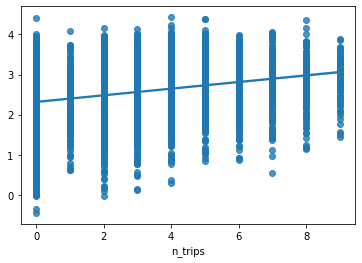

In [131]:
sns.regplot(y_test,LR_pred) #plotting predictions 

In [132]:
#calculate VIF scores to detect multicolinearity 

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = x_train_with_dist.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train_with_dist.values, i)
                          for i in range(len(x_train_with_dist.columns))]
  
print(vif_data)

                                feature        VIF
0                               NUMADLT  29.510298
1                            YOUNGCHILD  20.291842
2                              WRKCOUNT  60.887213
3                                EDUC_1   6.456246
4                                EDUC_2  21.060117
..                                  ...        ...
127  dist_to_relatvies_between_5_and_11   1.018572
128      dist_to_social_between_1_and_2   1.025226
129      dist_to_social_greater_than_11   1.056427
130      dist_to_social_between_2_and_5   1.042953
131     dist_to_social_between_5_and_11   1.041205

[132 rows x 2 columns]


In [133]:
vif_data.sort_values(by = 'VIF', ascending = False)

,feature,VIF
66,MSASIZE_2,inf
81,LIF_CYC_10,inf
84,LIF_CYC_4,inf
85,LIF_CYC_5,inf
86,LIF_CYC_6,inf
...,...,...
127,dist_to_relatvies_between_5_and_11,1.018572
121,dist_to_school_or_church_greater_than_11,1.018423
123,dist_to_school_or_church_between_5_and_11,1.018231
126,dist_to_relatvies_between_2_and_5,1.016029


In [134]:
# counting number of infinity features 

vif_data_inf = np.isinf(vif_data['VIF']).values.sum()
print("It contains " + str(vif_data_inf) + " infinite values")


It contains 66 infinite values


In [135]:
#cross validation to see if it will improve results 

folds = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = model_selection.cross_val_score(LRmodel, x_train_with_dist, y_train, scoring='r2', cv=folds)

print('\nR2 score:',scores)



R2 score: [-316582614288446912.000000 0.553914 0.559742 0.569041 0.568494]


In [146]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
scores


array([-316582614288446912.000000, 0.553914, 0.559742, 0.569041, 0.568494])

In [147]:
from sklearn.feature_selection import RFE
import time
start_time = time.time()
#specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1,109))}]


# perform grid search

rfe = RFE(LRmodel)             

# 3.2 call GridSearchCV()
model_cv = model_selection.GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 10,
                        return_train_score=True)      

# fit the model
model_cv.fit(x_train_with_dist, y_train)
print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5; 1/108] START n_features_to_select=1....................................
[CV 1/5; 1/108] END n_features_to_select=1;, score=(train=0.001, test=0.001) total time=   4.5s
[CV 2/5; 1/108] START n_features_to_select=1....................................
[CV 2/5; 1/108] END n_features_to_select=1;, score=(train=0.000, test=0.000) total time=   4.2s
[CV 3/5; 1/108] START n_features_to_select=1....................................
[CV 3/5; 1/108] END n_features_to_select=1;, score=(train=0.001, test=-0.002) total time=   4.0s
[CV 4/5; 1/108] START n_features_to_select=1....................................
[CV 4/5; 1/108] END n_features_to_select=1;, score=(train=0.003, test=0.002) total time=   4.2s
[CV 5/5; 1/108] START n_features_to_select=1....................................
[CV 5/5; 1/108] END n_features_to_select=1;, score=(train=0.000, test=-0.000) total time=   4.1s
[CV 1/5; 2/108] START n_features_to_select=2......

[CV 2/5; 10/108] END n_features_to_select=10;, score=(train=0.005, test=0.004) total time=   4.2s
[CV 3/5; 10/108] START n_features_to_select=10..................................
[CV 3/5; 10/108] END n_features_to_select=10;, score=(train=0.008, test=0.004) total time=   4.3s
[CV 4/5; 10/108] START n_features_to_select=10..................................
[CV 4/5; 10/108] END n_features_to_select=10;, score=(train=0.006, test=0.005) total time=   4.0s
[CV 5/5; 10/108] START n_features_to_select=10..................................
[CV 5/5; 10/108] END n_features_to_select=10;, score=(train=0.005, test=0.003) total time=   4.1s
[CV 1/5; 11/108] START n_features_to_select=11..................................
[CV 1/5; 11/108] END n_features_to_select=11;, score=(train=0.004, test=-16050840511451968307200.000) total time=   4.0s
[CV 2/5; 11/108] START n_features_to_select=11..................................
[CV 2/5; 11/108] END n_features_to_select=11;, score=(train=0.005, test=0.004) tot

[CV 2/5; 19/108] END n_features_to_select=19;, score=(train=0.012, test=0.012) total time=   4.3s
[CV 3/5; 19/108] START n_features_to_select=19..................................
[CV 3/5; 19/108] END n_features_to_select=19;, score=(train=0.012, test=0.010) total time=   3.9s
[CV 4/5; 19/108] START n_features_to_select=19..................................
[CV 4/5; 19/108] END n_features_to_select=19;, score=(train=0.008, test=0.008) total time=   4.1s
[CV 5/5; 19/108] START n_features_to_select=19..................................
[CV 5/5; 19/108] END n_features_to_select=19;, score=(train=0.008, test=0.006) total time=   4.1s
[CV 1/5; 20/108] START n_features_to_select=20..................................
[CV 1/5; 20/108] END n_features_to_select=20;, score=(train=0.014, test=-6271350063910537396224.000) total time=   4.1s
[CV 2/5; 20/108] START n_features_to_select=20..................................
[CV 2/5; 20/108] END n_features_to_select=20;, score=(train=0.012, test=0.012) tota

[CV 2/5; 28/108] END n_features_to_select=28;, score=(train=0.022, test=0.018) total time=   4.1s
[CV 3/5; 28/108] START n_features_to_select=28..................................
[CV 3/5; 28/108] END n_features_to_select=28;, score=(train=0.013, test=0.013) total time=   4.0s
[CV 4/5; 28/108] START n_features_to_select=28..................................
[CV 4/5; 28/108] END n_features_to_select=28;, score=(train=0.015, test=0.011) total time=   4.0s
[CV 5/5; 28/108] START n_features_to_select=28..................................
[CV 5/5; 28/108] END n_features_to_select=28;, score=(train=0.018, test=0.011) total time=   4.0s
[CV 1/5; 29/108] START n_features_to_select=29..................................
[CV 1/5; 29/108] END n_features_to_select=29;, score=(train=0.025, test=-6934538478665295986688.000) total time=   3.9s
[CV 2/5; 29/108] START n_features_to_select=29..................................
[CV 2/5; 29/108] END n_features_to_select=29;, score=(train=0.022, test=0.019) tota

[CV 2/5; 37/108] END n_features_to_select=37;, score=(train=0.026, test=0.024) total time=   3.8s
[CV 3/5; 37/108] START n_features_to_select=37..................................
[CV 3/5; 37/108] END n_features_to_select=37;, score=(train=0.025, test=0.032) total time=   4.1s
[CV 4/5; 37/108] START n_features_to_select=37..................................
[CV 4/5; 37/108] END n_features_to_select=37;, score=(train=0.024, test=0.020) total time=   3.8s
[CV 5/5; 37/108] START n_features_to_select=37..................................
[CV 5/5; 37/108] END n_features_to_select=37;, score=(train=0.029, test=0.020) total time=   3.8s
[CV 1/5; 38/108] START n_features_to_select=38..................................
[CV 1/5; 38/108] END n_features_to_select=38;, score=(train=0.032, test=-7974211028481338245120.000) total time=   3.9s
[CV 2/5; 38/108] START n_features_to_select=38..................................
[CV 2/5; 38/108] END n_features_to_select=38;, score=(train=0.027, test=0.024) tota

[CV 2/5; 46/108] END n_features_to_select=46;, score=(train=0.030, test=0.026) total time=   3.7s
[CV 3/5; 46/108] START n_features_to_select=46..................................
[CV 3/5; 46/108] END n_features_to_select=46;, score=(train=0.038, test=0.041) total time=   3.7s
[CV 4/5; 46/108] START n_features_to_select=46..................................
[CV 4/5; 46/108] END n_features_to_select=46;, score=(train=0.030, test=0.025) total time=   3.6s
[CV 5/5; 46/108] START n_features_to_select=46..................................
[CV 5/5; 46/108] END n_features_to_select=46;, score=(train=0.030, test=0.021) total time=   3.7s
[CV 1/5; 47/108] START n_features_to_select=47..................................
[CV 1/5; 47/108] END n_features_to_select=47;, score=(train=0.037, test=-19850947542886412976128.000) total time=   3.6s
[CV 2/5; 47/108] START n_features_to_select=47..................................
[CV 2/5; 47/108] END n_features_to_select=47;, score=(train=0.031, test=0.025) tot

[CV 2/5; 55/108] END n_features_to_select=55;, score=(train=0.043, test=0.033) total time=   3.5s
[CV 3/5; 55/108] START n_features_to_select=55..................................
[CV 3/5; 55/108] END n_features_to_select=55;, score=(train=0.042, test=0.042) total time=   3.6s
[CV 4/5; 55/108] START n_features_to_select=55..................................
[CV 4/5; 55/108] END n_features_to_select=55;, score=(train=0.044, test=0.041) total time=   3.5s
[CV 5/5; 55/108] START n_features_to_select=55..................................
[CV 5/5; 55/108] END n_features_to_select=55;, score=(train=0.032, test=0.022) total time=   3.5s
[CV 1/5; 56/108] START n_features_to_select=56..................................
[CV 1/5; 56/108] END n_features_to_select=56;, score=(train=0.041, test=-2547339394490970406912.000) total time=   3.5s
[CV 2/5; 56/108] START n_features_to_select=56..................................
[CV 2/5; 56/108] END n_features_to_select=56;, score=(train=0.043, test=0.033) tota

[CV 2/5; 64/108] END n_features_to_select=64;, score=(train=0.048, test=0.030) total time=   3.2s
[CV 3/5; 64/108] START n_features_to_select=64..................................
[CV 3/5; 64/108] END n_features_to_select=64;, score=(train=0.044, test=0.047) total time=   3.3s
[CV 4/5; 64/108] START n_features_to_select=64..................................
[CV 4/5; 64/108] END n_features_to_select=64;, score=(train=0.046, test=0.042) total time=   3.3s
[CV 5/5; 64/108] START n_features_to_select=64..................................
[CV 5/5; 64/108] END n_features_to_select=64;, score=(train=0.045, test=0.041) total time=   3.3s
[CV 1/5; 65/108] START n_features_to_select=65..................................
[CV 1/5; 65/108] END n_features_to_select=65;, score=(train=0.187, test=-3320926618341719146496.000) total time=   3.2s
[CV 2/5; 65/108] START n_features_to_select=65..................................
[CV 2/5; 65/108] END n_features_to_select=65;, score=(train=0.048, test=0.030) tota

[CV 2/5; 73/108] END n_features_to_select=73;, score=(train=0.329, test=0.300) total time=   3.1s
[CV 3/5; 73/108] START n_features_to_select=73..................................
[CV 3/5; 73/108] END n_features_to_select=73;, score=(train=0.332, test=0.332) total time=   3.2s
[CV 4/5; 73/108] START n_features_to_select=73..................................
[CV 4/5; 73/108] END n_features_to_select=73;, score=(train=0.331, test=0.339) total time=   3.0s
[CV 5/5; 73/108] START n_features_to_select=73..................................
[CV 5/5; 73/108] END n_features_to_select=73;, score=(train=0.334, test=0.326) total time=   3.1s
[CV 1/5; 74/108] START n_features_to_select=74..................................
[CV 1/5; 74/108] END n_features_to_select=74;, score=(train=0.458, test=-1582840459490222931968.000) total time=   3.0s
[CV 2/5; 74/108] START n_features_to_select=74..................................
[CV 2/5; 74/108] END n_features_to_select=74;, score=(train=0.360, test=0.339) tota

[CV 2/5; 82/108] END n_features_to_select=82;, score=(train=0.495, test=0.465) total time=   2.7s
[CV 3/5; 82/108] START n_features_to_select=82..................................
[CV 3/5; 82/108] END n_features_to_select=82;, score=(train=0.487, test=0.488) total time=   2.7s
[CV 4/5; 82/108] START n_features_to_select=82..................................
[CV 4/5; 82/108] END n_features_to_select=82;, score=(train=0.487, test=0.499) total time=   2.8s
[CV 5/5; 82/108] START n_features_to_select=82..................................
[CV 5/5; 82/108] END n_features_to_select=82;, score=(train=0.489, test=0.485) total time=   2.7s
[CV 1/5; 83/108] START n_features_to_select=83..................................
[CV 1/5; 83/108] END n_features_to_select=83;, score=(train=0.474, test=-1479011681598958592.000) total time=   2.9s
[CV 2/5; 83/108] START n_features_to_select=83..................................
[CV 2/5; 83/108] END n_features_to_select=83;, score=(train=0.499, test=0.470) total t

[CV 2/5; 91/108] END n_features_to_select=91;, score=(train=0.566, test=0.545) total time=   2.5s
[CV 3/5; 91/108] START n_features_to_select=91..................................
[CV 3/5; 91/108] END n_features_to_select=91;, score=(train=0.563, test=0.556) total time=   2.3s
[CV 4/5; 91/108] START n_features_to_select=91..................................
[CV 4/5; 91/108] END n_features_to_select=91;, score=(train=0.561, test=0.565) total time=   2.4s
[CV 5/5; 91/108] START n_features_to_select=91..................................
[CV 5/5; 91/108] END n_features_to_select=91;, score=(train=0.561, test=0.565) total time=   2.4s
[CV 1/5; 92/108] START n_features_to_select=92..................................
[CV 1/5; 92/108] END n_features_to_select=92;, score=(train=0.528, test=-587734297485961003008.000) total time=   2.3s
[CV 2/5; 92/108] START n_features_to_select=92..................................
[CV 2/5; 92/108] END n_features_to_select=92;, score=(train=0.566, test=0.546) total

[CV 2/5; 100/108] END n_features_to_select=100;, score=(train=0.569, test=0.551) total time=   1.9s
[CV 3/5; 100/108] START n_features_to_select=100................................
[CV 3/5; 100/108] END n_features_to_select=100;, score=(train=0.565, test=0.557) total time=   2.0s
[CV 4/5; 100/108] START n_features_to_select=100................................
[CV 4/5; 100/108] END n_features_to_select=100;, score=(train=0.563, test=0.566) total time=   2.0s
[CV 5/5; 100/108] START n_features_to_select=100................................
[CV 5/5; 100/108] END n_features_to_select=100;, score=(train=0.565, test=0.567) total time=   1.9s
[CV 1/5; 101/108] START n_features_to_select=101................................
[CV 1/5; 101/108] END n_features_to_select=101;, score=(train=0.563, test=-5992262576520984576.000) total time=   2.0s
[CV 2/5; 101/108] START n_features_to_select=101................................
[CV 2/5; 101/108] END n_features_to_select=101;, score=(train=0.570, test=0.

In [148]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.286501,0.156569,0.008399,0.003025,1,{'n_features_to_select': 1},1.299240e-03,0.000089,-0.001551,0.002491,...,4.509012e-04,1.363570e-03,8,0.000610,0.000316,0.001162,0.002670,0.000343,0.001020,0.000879
1,4.791002,0.329095,0.006898,0.002312,2,{'n_features_to_select': 2},1.882429e-03,0.000587,0.002083,0.003611,...,1.836872e-03,1.042985e-03,7,0.001294,0.000600,0.003542,0.003569,0.001536,0.002108,0.001221
2,4.274404,0.086404,0.005301,0.000245,3,{'n_features_to_select': 3},3.798272e-03,-0.000187,0.003421,0.003976,...,2.408673e-03,1.675516e-03,5,0.002622,0.000981,0.005226,0.003740,0.001536,0.002821,0.001530
3,4.219100,0.256829,0.006598,0.001279,4,{'n_features_to_select': 4},3.372466e-03,-0.000112,0.004099,0.003550,...,2.390404e-03,1.631355e-03,6,0.003331,0.000978,0.006254,0.003950,0.001528,0.003208,0.001878
4,4.774703,0.239719,0.006398,0.001069,5,{'n_features_to_select': 5},3.372836e-03,0.001403,0.004130,0.004207,...,2.835593e-03,1.344122e-03,3,0.003330,0.003941,0.007271,0.004066,0.001532,0.004028,0.001857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,1.968909,0.141498,0.007596,0.000372,104,{'n_features_to_select': 104},-2.018906e+20,0.552039,0.559382,0.569071,...,-4.037811e+19,8.075622e+19,27,0.565466,0.570001,0.567911,0.566064,0.565854,0.567059,0.001695
104,1.858503,0.126862,0.010799,0.003185,105,{'n_features_to_select': 105},-1.162674e+16,0.552536,0.560028,0.569031,...,-2.325348e+15,4.650696e+15,9,0.565578,0.570147,0.568235,0.566075,0.566090,0.567225,0.001725
105,1.797701,0.037247,0.007899,0.001068,106,{'n_features_to_select': 106},-7.366031e+17,0.552610,0.560170,0.569181,...,-1.473206e+17,2.946412e+17,10,0.565819,0.570148,0.568202,0.566159,0.566318,0.567329,0.001636
106,1.699200,0.039651,0.009699,0.002782,107,{'n_features_to_select': 107},-1.906294e+20,0.552694,0.560088,0.569427,...,-3.812587e+19,7.625174e+19,26,0.565746,0.570257,0.568526,0.566321,0.566143,0.567398,0.001727


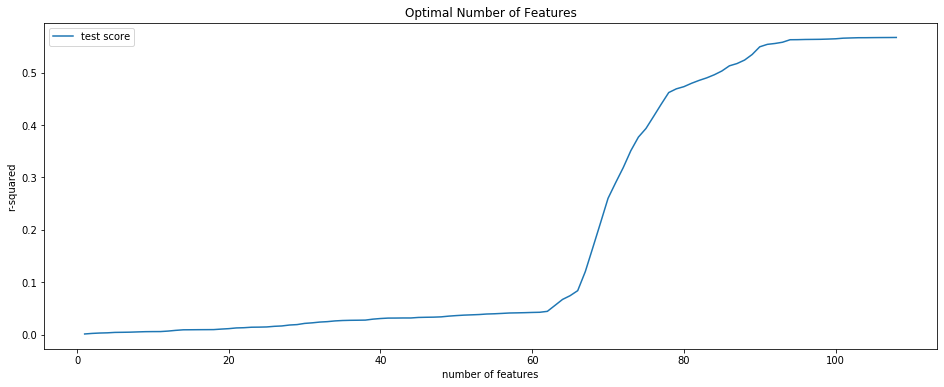

In [149]:
# plotting cv results
plt.figure(figsize=(16,6))

#plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')


#### 4.1.1.2 Linear Regression – Regularisation

**Lasso Regularisation**

In [150]:
alpha = [0.0001, 0.001, 0.005, 0.01]

for i in range(4):
    #build lasso regressor model here
    lasso = linear_model.Lasso(alpha=alpha[i])
    lasso.fit(x_train_with_dist, y_train) #fit a lasso regression on the training data
    y_predlasso = lasso.predict(x_test_with_dist) #use this model to predict the test data
    lasso_mse = metrics.mean_squared_error(y_test, y_predlasso) #calculate the test MSE
    lasso_rmse = metrics.mean_squared_error(y_test, y_predlasso,squared = False) #calculate the test RMSE
    msemanual = np.mean((y_predlasso-y_test)**2) #calculate mse manually to cross validate
    lasso_cplxy = (np.sum(abs(lasso.coef_))) #calculate l1norm / model complexity
    
    print('-' * 32)
    print('lasso with alpha', alpha[i])
    print('-' * 32)
    print('\nTrain score:', round(lasso.score(x_train_with_dist, y_train), 3)) #compute train R^2 score
    print('Test score:', round(lasso.score(x_test_with_dist, y_test), 3)) #compute test R^2 score
    print(list(map(lambda x: round(x, 3), lasso.coef_))) #list out the coef values 
    print('-' * 32)
    print('MSE on test set:', lasso_mse) #compute MSE results
    print('Manual MSE on test set:',msemanual) #compute MSE results
    print('RMSE on test set:', lasso_rmse) #compute RMSE results
    print('model complexity:', lasso_cplxy) #compute L1 NOMR score
    print('regularized cost:', lasso_mse + alpha[i] * lasso_cplxy) #compute regularised cost function scores
    print('\n')


--------------------------------
lasso with alpha 0.0001
--------------------------------

Train score: 0.568
Test score: 0.566
[-0.731, 0.0, 0.145, -0.227, -0.184, -0.118, -0.056, -0.052, -0.056, -0.123, -0.26, 0.084, -0.048, -0.131, -0.24, 0.002, 0.116, -0.0, 0.009, 0.0, 0.168, 0.108, 0.047, -0.153, 0.036, 0.848, 0.64, 0.152, -0.175, -0.051, 0.02, 0.082, -0.0, 0.071, -0.018, 0.112, -0.106, -0.038, 0.01, 0.003, -0.027, 0.0, 0.076, 0.037, -0.011, -0.01, 0.043, 0.045, -0.019, -0.027, -0.114, 0.029, 0.088, 0.023, 0.018, 0.1, 0.095, 0.063, 0.082, 0.037, 0.065, -0.006, 0.0, -0.0, 0.041, -0.0, 0.074, -0.026, 0.0, -0.0, 0.0, -0.4, 0.0, 0.021, -0.105, -0.048, -0.0, 0.215, 0.204, -0.0, -0.0, -0.104, -0.126, 0.0, 0.028, 0.005, -0.099, 0.003, -0.073, 0.081, -0.283, -0.18, -0.119, -0.073, 0.014, 0.0, 0.071, 0.096, 0.112, -0.132, -0.0, 0.141, 0.0, -0.188, 0.085, -0.071, 0.102, -0.01, 1.626, 1.254, 1.471, 1.375, 1.786, 1.834, 1.862, 1.939, 2.252, 1.987, 2.172, 2.118, 1.569, 1.448, 1.527, 1.58, 1.65

**Ridge Regularisation**

In [151]:
ridgealpha = [0.001, 0.01, 0.1, 1]

for i in range(4):
    #build ridge regressor here
    ridge = linear_model.Ridge(alpha=ridgealpha[i])
    ridge.fit(x_train_with_dist, y_train) #fit a ridge regression on the training data
    y_pred_ridge = ridge.predict(x_test_with_dist) #use this model to predict the test data
    ridge_mse = metrics.mean_squared_error(y_test, y_pred_ridge) #calculate the test mse
    ridge_rmse = metrics.mean_squared_error(y_test, y_pred_ridge,squared = False) #calculate the test rmse
    ridge_cplxy = (np.linalg.norm(ridge.coef_)) #calculate l2norm / model complexity
    
    print('-' * 32)
    print('ridge with alpha', ridgealpha[i])
    print('-' * 32)
    print('\nTrain score:', round(ridge.score(x_train_with_dist, y_train), 3))
    print('Test score:', round(ridge.score(x_test_with_dist, y_test), 3))
    print(list(map(lambda x: round(x, 3), ridge.coef_)))
    print('-' * 32)
    print('MSE on test set:', ridge_mse)
    print('RMSE on test set:', ridge_rmse)
    print('model complexity:', ridge_cplxy)
    print('regularized cost:', ridge_mse + ridgealpha[i] * ridge_cplxy)
    print('\n')


--------------------------------
ridge with alpha 0.001
--------------------------------

Train score: 0.568
Test score: 0.566
[-0.857, 0.345, 0.261, -0.297, -0.263, -0.198, -0.137, -0.133, -0.176, -0.246, -0.385, -0.001, -0.353, -0.256, -0.363, 0.251, 0.365, -1.343, -1.332, 0.365, 0.533, 1.086, 1.024, 0.821, 1.014, 2.023, 0.744, 0.252, -0.166, -0.041, 0.031, 0.092, 0.011, 0.082, -0.01, 0.085, -0.037, -0.069, 0.021, 0.135, 0.105, 0.135, 0.08, 0.01, -0.048, -0.041, 0.032, 0.035, -0.03, -0.037, -0.087, 0.06, 0.118, 0.056, 0.049, 0.13, 0.124, 0.094, 0.112, 0.068, 0.096, -0.037, 0.016, 0.005, 0.016, -0.014, 0.061, -0.041, 0.016, -0.037, 0.016, -0.152, 0.152, 0.005, -0.124, -0.065, -0.016, 0.201, 0.152, -0.152, -0.001, -0.073, -0.093, 0.031, 0.072, 0.039, -0.064, 0.045, -0.037, 0.081, -0.231, -0.128, -0.065, -0.017, 0.071, 0.086, 0.13, 0.155, 0.164, -0.164, -0.0, 0.255, 0.014, -0.27, 0.11, -0.162, 0.1, -0.048, 1.631, 1.256, 1.474, 1.377, 1.788, 1.837, 1.864, 1.94, 2.254, 1.989, 2.173, 2.119

### 4.2.1.3. Principal Component Regression

In [152]:
pca = PCA()
x_reduced = pca.fit_transform(scale(x_train_with_dist))

In [153]:
pd.DataFrame(pca.components_.T).loc[:4,:5]
#pd.DataFrame(pca.components_.T)

,0,1,2,3,4,5
0,-0.270902,-0.194997,-0.002249,-0.021970,0.000938,0.034461
1,0.173251,0.134481,-0.047238,0.101146,-0.023086,0.285606
2,0.008301,-0.097557,-0.349333,0.010191,-0.015625,-0.047923
3,0.061964,0.059343,0.069994,-0.026719,0.001765,-0.128893
4,-0.070860,0.013958,0.054563,0.002249,0.019730,0.034307


In [154]:
# 10-fold CV, with shuffle
kf_5 = model_selection.KFold(n_splits=5, shuffle=True, random_state=100)

pcascores = model_selection.cross_val_score(LRmodel, x_reduced, y_train, scoring='r2', cv=kf_10)

print('\nR2 score:',pcascores)



R2 score: [0.550579 -387255973098743988224.000000 0.550994 0.556148 0.556303
 0.562120 0.552666 0.586106 0.549240 0.585804]


In [155]:
#specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1,133))}]
   

# GridSearchCV()
pcamodel_cv = model_selection.GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = kf_5, 
                        verbose = 10,
                        return_train_score=True)      

# fit the model
pcamodel_cv.fit(x_reduced, y_train)  


Fitting 5 folds for each of 132 candidates, totalling 660 fits
[CV 1/5; 1/132] START n_features_to_select=1....................................
[CV 1/5; 1/132] END n_features_to_select=1;, score=(train=0.000, test=0.000) total time=   4.8s
[CV 2/5; 1/132] START n_features_to_select=1....................................
[CV 2/5; 1/132] END n_features_to_select=1;, score=(train=0.000, test=-0.001) total time=   4.7s
[CV 3/5; 1/132] START n_features_to_select=1....................................
[CV 3/5; 1/132] END n_features_to_select=1;, score=(train=0.000, test=-0.001) total time=   4.8s
[CV 4/5; 1/132] START n_features_to_select=1....................................
[CV 4/5; 1/132] END n_features_to_select=1;, score=(train=0.000, test=-0.000) total time=   4.8s
[CV 5/5; 1/132] START n_features_to_select=1....................................
[CV 5/5; 1/132] END n_features_to_select=1;, score=(train=0.000, test=-0.000) total time=   4.7s
[CV 1/5; 2/132] START n_features_to_select=2....

[CV 2/5; 10/132] END n_features_to_select=10;, score=(train=0.001, test=-0.021) total time=   4.6s
[CV 3/5; 10/132] START n_features_to_select=10..................................
[CV 3/5; 10/132] END n_features_to_select=10;, score=(train=0.000, test=-0.002) total time=   4.8s
[CV 4/5; 10/132] START n_features_to_select=10..................................
[CV 4/5; 10/132] END n_features_to_select=10;, score=(train=0.001, test=-0.008) total time=   4.8s
[CV 5/5; 10/132] START n_features_to_select=10..................................
[CV 5/5; 10/132] END n_features_to_select=10;, score=(train=0.001, test=-0.002) total time=   4.7s
[CV 1/5; 11/132] START n_features_to_select=11..................................
[CV 1/5; 11/132] END n_features_to_select=11;, score=(train=0.001, test=-0.011) total time=   4.7s
[CV 2/5; 11/132] START n_features_to_select=11..................................
[CV 2/5; 11/132] END n_features_to_select=11;, score=(train=0.001, test=-0.035) total time=   5.0s
[

[CV 3/5; 19/132] END n_features_to_select=19;, score=(train=0.001, test=-0.002) total time=   4.7s
[CV 4/5; 19/132] START n_features_to_select=19..................................
[CV 4/5; 19/132] END n_features_to_select=19;, score=(train=0.001, test=-0.041) total time=   4.6s
[CV 5/5; 19/132] START n_features_to_select=19..................................
[CV 5/5; 19/132] END n_features_to_select=19;, score=(train=0.001, test=-0.002) total time=   4.6s
[CV 1/5; 20/132] START n_features_to_select=20..................................
[CV 1/5; 20/132] END n_features_to_select=20;, score=(train=0.001, test=-0.032) total time=   4.6s
[CV 2/5; 20/132] START n_features_to_select=20..................................
[CV 2/5; 20/132] END n_features_to_select=20;, score=(train=0.001, test=-0.111) total time=   4.6s
[CV 3/5; 20/132] START n_features_to_select=20..................................
[CV 3/5; 20/132] END n_features_to_select=20;, score=(train=0.001, test=-0.002) total time=   4.6s
[

[CV 4/5; 28/132] END n_features_to_select=28;, score=(train=0.191, test=0.186) total time=   4.6s
[CV 5/5; 28/132] START n_features_to_select=28..................................
[CV 5/5; 28/132] END n_features_to_select=28;, score=(train=0.246, test=0.223) total time=   4.7s
[CV 1/5; 29/132] START n_features_to_select=29..................................
[CV 1/5; 29/132] END n_features_to_select=29;, score=(train=0.169, test=-29.749) total time=   4.6s
[CV 2/5; 29/132] START n_features_to_select=29..................................
[CV 2/5; 29/132] END n_features_to_select=29;, score=(train=0.265, test=0.255) total time=   4.8s
[CV 3/5; 29/132] START n_features_to_select=29..................................
[CV 3/5; 29/132] END n_features_to_select=29;, score=(train=0.241, test=0.244) total time=   4.6s
[CV 4/5; 29/132] START n_features_to_select=29..................................
[CV 4/5; 29/132] END n_features_to_select=29;, score=(train=0.241, test=0.239) total time=   4.5s
[CV 5

[CV 5/5; 37/132] END n_features_to_select=37;, score=(train=0.329, test=0.305) total time=   4.3s
[CV 1/5; 38/132] START n_features_to_select=38..................................
[CV 1/5; 38/132] END n_features_to_select=38;, score=(train=0.237, test=-73.334) total time=   4.4s
[CV 2/5; 38/132] START n_features_to_select=38..................................
[CV 2/5; 38/132] END n_features_to_select=38;, score=(train=0.355, test=0.344) total time=   4.4s
[CV 3/5; 38/132] START n_features_to_select=38..................................
[CV 3/5; 38/132] END n_features_to_select=38;, score=(train=0.350, test=0.349) total time=   4.4s
[CV 4/5; 38/132] START n_features_to_select=38..................................
[CV 4/5; 38/132] END n_features_to_select=38;, score=(train=0.355, test=0.349) total time=   4.6s
[CV 5/5; 38/132] START n_features_to_select=38..................................
[CV 5/5; 38/132] END n_features_to_select=38;, score=(train=0.338, test=0.317) total time=   4.4s
[CV 1

[CV 1/5; 47/132] END n_features_to_select=47;, score=(train=0.284, test=-180.538) total time=   4.2s
[CV 2/5; 47/132] START n_features_to_select=47..................................
[CV 2/5; 47/132] END n_features_to_select=47;, score=(train=0.418, test=0.407) total time=   4.3s
[CV 3/5; 47/132] START n_features_to_select=47..................................
[CV 3/5; 47/132] END n_features_to_select=47;, score=(train=0.415, test=0.422) total time=   4.2s
[CV 4/5; 47/132] START n_features_to_select=47..................................
[CV 4/5; 47/132] END n_features_to_select=47;, score=(train=0.417, test=0.410) total time=   4.4s
[CV 5/5; 47/132] START n_features_to_select=47..................................
[CV 5/5; 47/132] END n_features_to_select=47;, score=(train=0.383, test=0.358) total time=   4.2s
[CV 1/5; 48/132] START n_features_to_select=48..................................
[CV 1/5; 48/132] END n_features_to_select=48;, score=(train=0.284, test=-180.555) total time=   4.2s
[

[CV 2/5; 56/132] END n_features_to_select=56;, score=(train=0.453, test=0.441) total time=   4.0s
[CV 3/5; 56/132] START n_features_to_select=56..................................
[CV 3/5; 56/132] END n_features_to_select=56;, score=(train=0.448, test=0.448) total time=   3.9s
[CV 4/5; 56/132] START n_features_to_select=56..................................
[CV 4/5; 56/132] END n_features_to_select=56;, score=(train=0.451, test=0.445) total time=   3.9s
[CV 5/5; 56/132] START n_features_to_select=56..................................
[CV 5/5; 56/132] END n_features_to_select=56;, score=(train=0.278, test=0.259) total time=   4.3s
[CV 1/5; 57/132] START n_features_to_select=57..................................
[CV 1/5; 57/132] END n_features_to_select=57;, score=(train=0.349, test=-511.643) total time=   4.0s
[CV 2/5; 57/132] START n_features_to_select=57..................................
[CV 2/5; 57/132] END n_features_to_select=57;, score=(train=0.457, test=0.444) total time=   4.0s
[CV 

[CV 3/5; 65/132] END n_features_to_select=65;, score=(train=0.476, test=0.470) total time=   3.7s
[CV 4/5; 65/132] START n_features_to_select=65..................................
[CV 4/5; 65/132] END n_features_to_select=65;, score=(train=0.480, test=0.477) total time=   3.6s
[CV 5/5; 65/132] START n_features_to_select=65..................................
[CV 5/5; 65/132] END n_features_to_select=65;, score=(train=0.484, test=0.470) total time=   3.7s
[CV 1/5; 66/132] START n_features_to_select=66..................................
[CV 1/5; 66/132] END n_features_to_select=66;, score=(train=0.396, test=-713.334) total time=   4.3s
[CV 2/5; 66/132] START n_features_to_select=66..................................
[CV 2/5; 66/132] END n_features_to_select=66;, score=(train=0.480, test=0.467) total time=   4.0s
[CV 3/5; 66/132] START n_features_to_select=66..................................
[CV 3/5; 66/132] END n_features_to_select=66;, score=(train=0.482, test=0.476) total time=   3.8s
[CV 

[CV 4/5; 74/132] END n_features_to_select=74;, score=(train=0.506, test=0.504) total time=   4.5s
[CV 5/5; 74/132] START n_features_to_select=74..................................
[CV 5/5; 74/132] END n_features_to_select=74;, score=(train=0.513, test=0.507) total time=   4.6s
[CV 1/5; 75/132] START n_features_to_select=75..................................
[CV 1/5; 75/132] END n_features_to_select=75;, score=(train=0.422, test=-1320.610) total time=   5.0s
[CV 2/5; 75/132] START n_features_to_select=75..................................
[CV 2/5; 75/132] END n_features_to_select=75;, score=(train=0.518, test=0.501) total time=   3.5s
[CV 3/5; 75/132] START n_features_to_select=75..................................
[CV 3/5; 75/132] END n_features_to_select=75;, score=(train=0.514, test=0.510) total time=   3.3s
[CV 4/5; 75/132] START n_features_to_select=75..................................
[CV 4/5; 75/132] END n_features_to_select=75;, score=(train=0.510, test=0.512) total time=   3.2s
[CV

[CV 5/5; 83/132] END n_features_to_select=83;, score=(train=0.543, test=0.533) total time=   3.1s
[CV 1/5; 84/132] START n_features_to_select=84..................................
[CV 1/5; 84/132] END n_features_to_select=84;, score=(train=0.472, test=-1874.026) total time=   3.1s
[CV 2/5; 84/132] START n_features_to_select=84..................................
[CV 2/5; 84/132] END n_features_to_select=84;, score=(train=0.540, test=0.527) total time=   3.2s
[CV 3/5; 84/132] START n_features_to_select=84..................................
[CV 3/5; 84/132] END n_features_to_select=84;, score=(train=0.542, test=0.539) total time=   3.2s
[CV 4/5; 84/132] START n_features_to_select=84..................................
[CV 4/5; 84/132] END n_features_to_select=84;, score=(train=0.542, test=0.545) total time=   3.1s
[CV 5/5; 84/132] START n_features_to_select=84..................................
[CV 5/5; 84/132] END n_features_to_select=84;, score=(train=0.545, test=0.535) total time=   3.0s
[CV

[CV 1/5; 93/132] END n_features_to_select=93;, score=(train=0.515, test=-3021.746) total time=   2.6s
[CV 2/5; 93/132] START n_features_to_select=93..................................
[CV 2/5; 93/132] END n_features_to_select=93;, score=(train=0.557, test=0.543) total time=   2.7s
[CV 3/5; 93/132] START n_features_to_select=93..................................
[CV 3/5; 93/132] END n_features_to_select=93;, score=(train=0.560, test=0.554) total time=   2.6s
[CV 4/5; 93/132] START n_features_to_select=93..................................
[CV 4/5; 93/132] END n_features_to_select=93;, score=(train=0.557, test=0.560) total time=   2.6s
[CV 5/5; 93/132] START n_features_to_select=93..................................
[CV 5/5; 93/132] END n_features_to_select=93;, score=(train=0.557, test=0.553) total time=   2.6s
[CV 1/5; 94/132] START n_features_to_select=94..................................
[CV 1/5; 94/132] END n_features_to_select=94;, score=(train=0.517, test=-3257.153) total time=   2.6s

[CV 2/5; 102/132] END n_features_to_select=102;, score=(train=0.559, test=0.541) total time=   2.1s
[CV 3/5; 102/132] START n_features_to_select=102................................
[CV 3/5; 102/132] END n_features_to_select=102;, score=(train=0.562, test=0.554) total time=   2.1s
[CV 4/5; 102/132] START n_features_to_select=102................................
[CV 4/5; 102/132] END n_features_to_select=102;, score=(train=0.561, test=0.564) total time=   2.1s
[CV 5/5; 102/132] START n_features_to_select=102................................
[CV 5/5; 102/132] END n_features_to_select=102;, score=(train=0.562, test=0.564) total time=   2.1s
[CV 1/5; 103/132] START n_features_to_select=103................................
[CV 1/5; 103/132] END n_features_to_select=103;, score=(train=0.534, test=-4373.845) total time=   2.1s
[CV 2/5; 103/132] START n_features_to_select=103................................
[CV 2/5; 103/132] END n_features_to_select=103;, score=(train=0.564, test=0.546) total time

[CV 3/5; 111/132] END n_features_to_select=111;, score=(train=0.568, test=0.558) total time=   1.6s
[CV 4/5; 111/132] START n_features_to_select=111................................
[CV 4/5; 111/132] END n_features_to_select=111;, score=(train=0.550, test=0.553) total time=   1.6s
[CV 5/5; 111/132] START n_features_to_select=111................................
[CV 5/5; 111/132] END n_features_to_select=111;, score=(train=0.564, test=0.563) total time=   1.6s
[CV 1/5; 112/132] START n_features_to_select=112................................
[CV 1/5; 112/132] END n_features_to_select=112;, score=(train=0.547, test=-10522.705) total time=   1.4s
[CV 2/5; 112/132] START n_features_to_select=112................................
[CV 2/5; 112/132] END n_features_to_select=112;, score=(train=0.570, test=0.552) total time=   1.5s
[CV 3/5; 112/132] START n_features_to_select=112................................
[CV 3/5; 112/132] END n_features_to_select=112;, score=(train=0.569, test=0.559) total tim

[CV 4/5; 120/132] END n_features_to_select=120;, score=(train=0.567, test=0.569) total time=   1.0s
[CV 5/5; 120/132] START n_features_to_select=120................................
[CV 5/5; 120/132] END n_features_to_select=120;, score=(train=0.568, test=0.568) total time=   1.0s
[CV 1/5; 121/132] START n_features_to_select=121................................
[CV 1/5; 121/132] END n_features_to_select=121;, score=(train=0.557, test=-21463.872) total time=   0.9s
[CV 2/5; 121/132] START n_features_to_select=121................................
[CV 2/5; 121/132] END n_features_to_select=121;, score=(train=0.571, test=0.553) total time=   0.8s
[CV 3/5; 121/132] START n_features_to_select=121................................
[CV 3/5; 121/132] END n_features_to_select=121;, score=(train=0.570, test=0.559) total time=   0.9s
[CV 4/5; 121/132] START n_features_to_select=121................................
[CV 4/5; 121/132] END n_features_to_select=121;, score=(train=0.558, test=0.561) total tim

[CV 5/5; 129/132] END n_features_to_select=129;, score=(train=0.568, test=0.568) total time=   0.3s
[CV 1/5; 130/132] START n_features_to_select=130................................
[CV 1/5; 130/132] END n_features_to_select=130;, score=(train=0.565, test=-254312.723) total time=   0.2s
[CV 2/5; 130/132] START n_features_to_select=130................................
[CV 2/5; 130/132] END n_features_to_select=130;, score=(train=0.571, test=0.553) total time=   0.2s
[CV 3/5; 130/132] START n_features_to_select=130................................
[CV 3/5; 130/132] END n_features_to_select=130;, score=(train=0.570, test=0.560) total time=   0.2s
[CV 4/5; 130/132] START n_features_to_select=130................................
[CV 4/5; 130/132] END n_features_to_select=130;, score=(train=0.546, test=0.551) total time=   0.2s
[CV 5/5; 130/132] START n_features_to_select=130................................
[CV 5/5; 130/132] END n_features_to_select=130;, score=(train=0.568, test=0.569) total ti

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, 30, ...]}],
             return_train_score=True, scoring='r2', verbose=10)

In [156]:
pcacv_results = pd.DataFrame(pcamodel_cv.cv_results_)
pcacv_results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.830099,0.038225,0.002000,0.000632,1,{'n_features_to_select': 1},5.989377e-05,-0.000604,-0.000961,-0.000427,...,-4.689905e-04,3.302021e-04,1,0.000010,0.000055,0.000059,0.000132,0.000041,0.000059,0.000040
1,4.827498,0.074064,0.002200,0.000244,2,{'n_features_to_select': 2},-3.282751e-04,-0.000609,-0.001010,-0.000379,...,-6.120751e-04,2.483807e-04,2,0.000080,0.000096,0.000101,0.000162,0.000132,0.000114,0.000029
2,4.907601,0.122506,0.002201,0.000748,3,{'n_features_to_select': 3},-2.003941e-04,-0.000785,-0.001404,-0.000952,...,-8.297016e-04,3.856865e-04,3,0.000128,0.000133,0.000200,0.000265,0.000144,0.000174,0.000052
3,4.766300,0.094123,0.002200,0.000245,4,{'n_features_to_select': 4},-5.969007e-04,-0.000786,-0.001731,-0.001203,...,-1.064595e-03,3.905174e-04,4,0.000176,0.000134,0.000273,0.000272,0.000257,0.000223,0.000057
4,4.855102,0.146765,0.002200,0.000401,5,{'n_features_to_select': 5},-1.718482e-03,-0.003796,-0.001662,-0.006141,...,-2.966978e-03,1.795988e-03,5,0.000343,0.000290,0.000291,0.000684,0.000400,0.000402,0.000147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,0.439402,0.010548,0.005598,0.000490,128,{'n_features_to_select': 128},-7.580037e+04,0.553892,0.560221,0.540757,...,-1.515963e+04,3.032037e+04,128,0.559502,0.571128,0.569802,0.536764,0.567712,0.560982,0.012765
128,0.360697,0.023748,0.005496,0.000316,129,{'n_features_to_select': 129},-3.035979e+05,0.553883,0.560190,0.543624,...,-6.071914e+04,1.214394e+05,131,0.567477,0.571196,0.569753,0.539577,0.567719,0.563144,0.011863
129,0.268208,0.004960,0.006990,0.001585,130,{'n_features_to_select': 130},-2.543127e+05,0.553310,0.560408,0.551302,...,-5.086210e+04,1.017253e+05,129,0.564528,0.570718,0.569777,0.546332,0.567644,0.563800,0.008989
130,0.199207,0.015400,0.007491,0.001212,131,{'n_features_to_select': 131},-2.953108e+05,0.553923,0.560122,0.569311,...,-5.906172e+04,1.181246e+05,130,0.567679,0.571205,0.569771,0.567429,0.567645,0.568746,0.001495


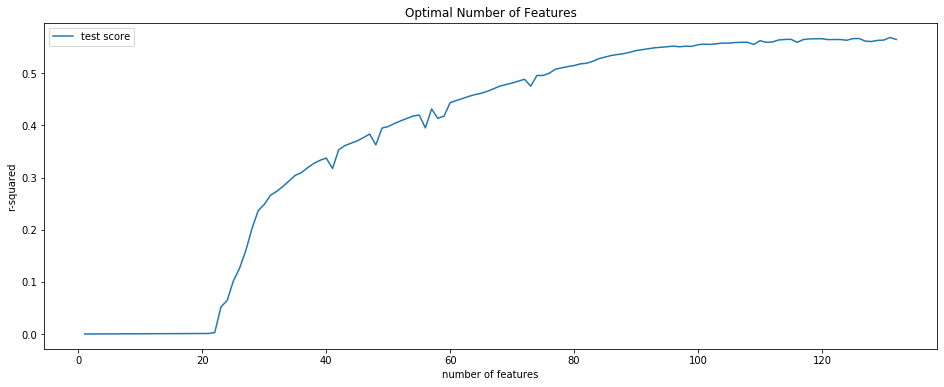

In [157]:
# plotting cv results
plt.figure(figsize=(16,6))

#plt.plot(cv_results["param_n_features_to_select"], pcacv_results["mean_test_score"])
plt.plot(pcacv_results["param_n_features_to_select"], pcacv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')


Text(0, 0.5, 'cumulative explained variance')

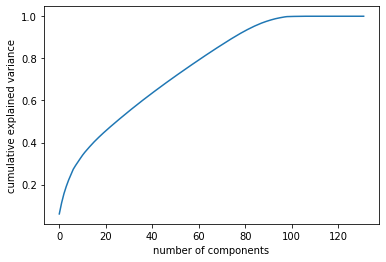

In [158]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')


### 4.2.2.1. Random Forest

In [159]:

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_features': [15, 17, 19],
    'oob_score': [True],
    'n_estimators': [900, 1200, 1500]
}
# Create a based model
rfgs = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfgs, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 3)
#wrapper_gs = RegressorChain(grid_search)
grid_search.fit(x_train_with_dist, y_train)

#grid_search.fit(train_features, train_labels)
print(grid_search.best_params_)

print(grid_search.best_estimator_)
print(grid_search.best_score_)

y_pred_rfgs = grid_search.predict(x_test_with_dist)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfgs))
print("RMSE: %f" % (rmse))

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred_rfgs))
# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, y_pred_rfgs))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'bootstrap': True, 'max_features': 19, 'n_estimators': 1500, 'oob_score': True}
RandomForestRegressor(max_features=19, n_estimators=1500, oob_score=True)
0.5631631488163865
RMSE: 1.519792
Mean squared error: 2.31
R2 score: 0.58


Model Preformance
Average Error: 1.1174 degrees.
Accuracy = -inf%,
rmse 1.5197919315421848
mse 2.309767515180725
R square: 0.5810738152651381
__________
Top 5 Features
dist_to_family_between_2_and_5 0.05041502665638511
dist_to_family_between_5_and_11 0.04706905670103904
dist_to_shopping_between_2_and_5 0.04487336986799223
dist_to_social_between_2_and_5 0.04460502291100863
dist_to_shopping_between_5_and_11 0.0369417948505883


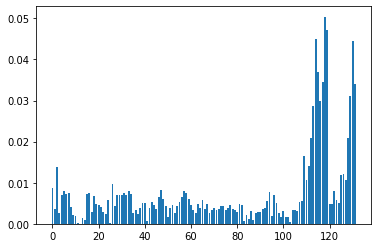

In [162]:
best_rf = grid_search.best_estimator_
rf_accuracy = evaluate_model(best_rf, x_test_with_dist, y_test)

### 4.2.3. Neural Network

In [85]:
train_df = pd.concat([y_train,x_train_with_dist], axis = 1)
test_df = pd.concat([y_test, x_train_with_dist],axis =1)
test_df.rename(columns = {'HHSIZE_ above_3':'HHSIZE_above_3'} , inplace = True)

In [88]:
#use the same param_grid as earlier
import time
start_time = time.time()

input_shape = [x_train_with_dist.shape[1]]
learn_rate = ((0.01),(0.1),(0.3))
batch_size = ((128,),(256,))
dropout_rate = ((0.1),(0),(0.2))
name = ['deep']
kernel_reg = ((tf.keras.regularizers.l2(0.04)),('glorot_uniform'))
layers = ((64,32,16,8),(64,16,8,4),(64,16),(100,64,32,16,8,4),(30,20,10,8))

 
param_grid = dict(input_shape = input_shape,
                  learn_rate = learn_rate,
                  dropout_rate = dropout_rate,
                  layers = layers,
                  kernel_reg = kernel_reg)

    
model_deep = KerasRegressor(build_fn = create_model_deep, epochs = 1000, batch_size = 256, verbose =2)
nn_grid = RandomizedSearchCV(estimator = model_deep, param_distributions = param_grid, n_jobs = -1, scoring='neg_mean_squared_error',verbose =5, cv = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 888))
nn_grid_result = nn_grid.fit(x_train_with_dist, y_train)
best_nn = nn_grid.best_estimator_

print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Epoch 1/1000
100/100 - 1s - loss: 4.7827 - mean_squared_error: 3.4872
Epoch 2/1000
100/100 - 0s - loss: 3.2959 - mean_squared_error: 2.8164
Epoch 3/1000
100/100 - 0s - loss: 3.1866 - mean_squared_error: 2.8038
Epoch 4/1000
100/100 - 0s - loss: 3.1054 - mean_squared_error: 2.7600
Epoch 5/1000
100/100 - 0s - loss: 3.0479 - mean_squared_error: 2.7484
Epoch 6/1000
100/100 - 0s - loss: 2.9924 - mean_squared_error: 2.7177
Epoch 7/1000
100/100 - 0s - loss: 2.9533 - mean_squared_error: 2.7038
Epoch 8/1000
100/100 - 0s - loss: 2.9388 - mean_squared_error: 2.7087
Epoch 9/1000
100/100 - 0s - loss: 2.9219 - mean_squared_error: 2.6986
Epoch 10/1000
100/100 - 0s - loss: 2.8926 - mean_squared_error: 2.6803
Epoch 11/1000
100/100 - 0s - loss: 2.8931 - mean_squared_error: 2.6915
Epoch 12/1000
100/100 - 0s - loss: 2.8801 - mean_squared_error: 2.6834
Epoch 13/1000
100/100 - 0s - loss: 2.8885 - mean_squared_error: 2.6972
Epoch 14/1000
100/100 - 0

Epoch 114/1000
100/100 - 0s - loss: 2.8170 - mean_squared_error: 2.6839
Epoch 115/1000
100/100 - 0s - loss: 2.7963 - mean_squared_error: 2.6821
Epoch 116/1000
100/100 - 0s - loss: 2.8050 - mean_squared_error: 2.6892
Epoch 117/1000
100/100 - 0s - loss: 2.7863 - mean_squared_error: 2.6722
Epoch 118/1000
100/100 - 0s - loss: 2.7891 - mean_squared_error: 2.6739
Epoch 119/1000
100/100 - 0s - loss: 2.8037 - mean_squared_error: 2.6911
Epoch 120/1000
100/100 - 0s - loss: 2.7974 - mean_squared_error: 2.6841
Epoch 121/1000
100/100 - 0s - loss: 2.8111 - mean_squared_error: 2.6956
Epoch 122/1000
100/100 - 0s - loss: 2.8088 - mean_squared_error: 2.6926
Epoch 123/1000
100/100 - 0s - loss: 2.8468 - mean_squared_error: 2.7268
Epoch 124/1000
100/100 - 0s - loss: 2.7865 - mean_squared_error: 2.6659
Epoch 125/1000
100/100 - 0s - loss: 2.8033 - mean_squared_error: 2.6857
Epoch 126/1000
100/100 - 0s - loss: 2.8344 - mean_squared_error: 2.7163
Epoch 127/1000
100/100 - 0s - loss: 2.8397 - mean_squared_error:

Epoch 228/1000
100/100 - 0s - loss: 2.8306 - mean_squared_error: 2.7144
Epoch 229/1000
100/100 - 0s - loss: 2.8064 - mean_squared_error: 2.6920
Epoch 230/1000
100/100 - 0s - loss: 2.8169 - mean_squared_error: 2.6995
Epoch 231/1000
100/100 - 0s - loss: 2.8072 - mean_squared_error: 2.6934
Epoch 232/1000
100/100 - 0s - loss: 2.8253 - mean_squared_error: 2.7089
Epoch 233/1000
100/100 - 0s - loss: 2.8183 - mean_squared_error: 2.7017
Epoch 234/1000
100/100 - 0s - loss: 2.8209 - mean_squared_error: 2.7057
Epoch 235/1000
100/100 - 0s - loss: 2.8236 - mean_squared_error: 2.7034
Epoch 236/1000
100/100 - 0s - loss: 2.8349 - mean_squared_error: 2.7159
Epoch 237/1000
100/100 - 0s - loss: 2.8169 - mean_squared_error: 2.6966
Epoch 238/1000
100/100 - 0s - loss: 2.8247 - mean_squared_error: 2.7074
Epoch 239/1000
100/100 - 0s - loss: 2.8025 - mean_squared_error: 2.6848
Epoch 240/1000
100/100 - 0s - loss: 2.8082 - mean_squared_error: 2.6931
Epoch 241/1000
100/100 - 0s - loss: 2.8234 - mean_squared_error:

Epoch 342/1000
100/100 - 0s - loss: 2.8165 - mean_squared_error: 2.7002
Epoch 343/1000
100/100 - 0s - loss: 2.8257 - mean_squared_error: 2.7063
Epoch 344/1000
100/100 - 0s - loss: 2.8157 - mean_squared_error: 2.6942
Epoch 345/1000
100/100 - 0s - loss: 2.7957 - mean_squared_error: 2.6768
Epoch 346/1000
100/100 - 0s - loss: 2.8082 - mean_squared_error: 2.6941
Epoch 347/1000
100/100 - 0s - loss: 2.8081 - mean_squared_error: 2.6924
Epoch 348/1000
100/100 - 0s - loss: 2.7809 - mean_squared_error: 2.6647
Epoch 349/1000
100/100 - 0s - loss: 2.8030 - mean_squared_error: 2.6874
Epoch 350/1000
100/100 - 0s - loss: 2.8040 - mean_squared_error: 2.6914
Epoch 351/1000
100/100 - 0s - loss: 2.8026 - mean_squared_error: 2.6902
Epoch 352/1000
100/100 - 0s - loss: 2.8347 - mean_squared_error: 2.7197
Epoch 353/1000
100/100 - 0s - loss: 2.8245 - mean_squared_error: 2.7078
Epoch 354/1000
100/100 - 0s - loss: 2.8112 - mean_squared_error: 2.6927
Epoch 355/1000
100/100 - 0s - loss: 2.8328 - mean_squared_error:

Epoch 456/1000
100/100 - 0s - loss: 2.8088 - mean_squared_error: 2.6953
Epoch 457/1000
100/100 - 0s - loss: 2.8171 - mean_squared_error: 2.7001
Epoch 458/1000
100/100 - 0s - loss: 2.7964 - mean_squared_error: 2.6820
Epoch 459/1000
100/100 - 0s - loss: 2.8002 - mean_squared_error: 2.6866
Epoch 460/1000
100/100 - 0s - loss: 2.8058 - mean_squared_error: 2.6921
Epoch 461/1000
100/100 - 0s - loss: 2.8241 - mean_squared_error: 2.7093
Epoch 462/1000
100/100 - 0s - loss: 2.8194 - mean_squared_error: 2.7022
Epoch 463/1000
100/100 - 0s - loss: 2.7808 - mean_squared_error: 2.6656
Epoch 464/1000
100/100 - 0s - loss: 2.8169 - mean_squared_error: 2.7036
Epoch 465/1000
100/100 - 0s - loss: 2.8145 - mean_squared_error: 2.6991
Epoch 466/1000
100/100 - 0s - loss: 2.8098 - mean_squared_error: 2.6940
Epoch 467/1000
100/100 - 0s - loss: 2.8239 - mean_squared_error: 2.7064
Epoch 468/1000
100/100 - 0s - loss: 2.7903 - mean_squared_error: 2.6762
Epoch 469/1000
100/100 - 0s - loss: 2.7708 - mean_squared_error:

Epoch 570/1000
100/100 - 0s - loss: 2.7918 - mean_squared_error: 2.6734
Epoch 571/1000
100/100 - 0s - loss: 2.8228 - mean_squared_error: 2.7038
Epoch 572/1000
100/100 - 0s - loss: 2.8191 - mean_squared_error: 2.6974
Epoch 573/1000
100/100 - 0s - loss: 2.8241 - mean_squared_error: 2.7044
Epoch 574/1000
100/100 - 0s - loss: 2.8270 - mean_squared_error: 2.7084
Epoch 575/1000
100/100 - 0s - loss: 2.8285 - mean_squared_error: 2.7082
Epoch 576/1000
100/100 - 0s - loss: 2.8014 - mean_squared_error: 2.6835
Epoch 577/1000
100/100 - 0s - loss: 2.8086 - mean_squared_error: 2.6889
Epoch 578/1000
100/100 - 0s - loss: 2.7874 - mean_squared_error: 2.6692
Epoch 579/1000
100/100 - 0s - loss: 2.7970 - mean_squared_error: 2.6822
Epoch 580/1000
100/100 - 0s - loss: 2.8159 - mean_squared_error: 2.7014
Epoch 581/1000
100/100 - 0s - loss: 2.8128 - mean_squared_error: 2.6936
Epoch 582/1000
100/100 - 0s - loss: 2.8119 - mean_squared_error: 2.6969
Epoch 583/1000
100/100 - 0s - loss: 2.8056 - mean_squared_error:

Epoch 684/1000
100/100 - 0s - loss: 2.8102 - mean_squared_error: 2.6897
Epoch 685/1000
100/100 - 0s - loss: 2.7809 - mean_squared_error: 2.6639
Epoch 686/1000
100/100 - 0s - loss: 2.7892 - mean_squared_error: 2.6756
Epoch 687/1000
100/100 - 0s - loss: 2.8196 - mean_squared_error: 2.7030
Epoch 688/1000
100/100 - 0s - loss: 2.7904 - mean_squared_error: 2.6738
Epoch 689/1000
100/100 - 0s - loss: 2.8032 - mean_squared_error: 2.6899
Epoch 690/1000
100/100 - 0s - loss: 2.8304 - mean_squared_error: 2.7181
Epoch 691/1000
100/100 - 0s - loss: 2.8407 - mean_squared_error: 2.7224
Epoch 692/1000
100/100 - 0s - loss: 2.8067 - mean_squared_error: 2.6916
Epoch 693/1000
100/100 - 0s - loss: 2.7907 - mean_squared_error: 2.6752
Epoch 694/1000
100/100 - 0s - loss: 2.8063 - mean_squared_error: 2.6923
Epoch 695/1000
100/100 - 0s - loss: 2.7895 - mean_squared_error: 2.6789
Epoch 696/1000
100/100 - 0s - loss: 2.8266 - mean_squared_error: 2.7135
Epoch 697/1000
100/100 - 0s - loss: 2.7961 - mean_squared_error:

Epoch 798/1000
100/100 - 0s - loss: 2.8234 - mean_squared_error: 2.7047
Epoch 799/1000
100/100 - 0s - loss: 2.8078 - mean_squared_error: 2.6878
Epoch 800/1000
100/100 - 0s - loss: 2.7902 - mean_squared_error: 2.6757
Epoch 801/1000
100/100 - 0s - loss: 2.8172 - mean_squared_error: 2.7006
Epoch 802/1000
100/100 - 0s - loss: 2.7965 - mean_squared_error: 2.6814
Epoch 803/1000
100/100 - 0s - loss: 2.8155 - mean_squared_error: 2.7015
Epoch 804/1000
100/100 - 0s - loss: 2.8430 - mean_squared_error: 2.7273
Epoch 805/1000
100/100 - 0s - loss: 2.8065 - mean_squared_error: 2.6879
Epoch 806/1000
100/100 - 0s - loss: 2.8198 - mean_squared_error: 2.7048
Epoch 807/1000
100/100 - 0s - loss: 2.8060 - mean_squared_error: 2.6909
Epoch 808/1000
100/100 - 0s - loss: 2.8158 - mean_squared_error: 2.7025
Epoch 809/1000
100/100 - 0s - loss: 2.7945 - mean_squared_error: 2.6778
Epoch 810/1000
100/100 - 0s - loss: 2.7952 - mean_squared_error: 2.6824
Epoch 811/1000
100/100 - 0s - loss: 2.8565 - mean_squared_error:

Epoch 912/1000
100/100 - 0s - loss: 2.8001 - mean_squared_error: 2.6858
Epoch 913/1000
100/100 - 0s - loss: 2.8103 - mean_squared_error: 2.6949
Epoch 914/1000
100/100 - 0s - loss: 2.8095 - mean_squared_error: 2.6963
Epoch 915/1000
100/100 - 0s - loss: 2.7807 - mean_squared_error: 2.6698
Epoch 916/1000
100/100 - 0s - loss: 2.8191 - mean_squared_error: 2.7059
Epoch 917/1000
100/100 - 0s - loss: 2.7995 - mean_squared_error: 2.6837
Epoch 918/1000
100/100 - 0s - loss: 2.8094 - mean_squared_error: 2.6936
Epoch 919/1000
100/100 - 0s - loss: 2.8283 - mean_squared_error: 2.7104
Epoch 920/1000
100/100 - 0s - loss: 2.8160 - mean_squared_error: 2.6977
Epoch 921/1000
100/100 - 0s - loss: 2.8337 - mean_squared_error: 2.7182
Epoch 922/1000
100/100 - 0s - loss: 2.7850 - mean_squared_error: 2.6730
Epoch 923/1000
100/100 - 0s - loss: 2.8076 - mean_squared_error: 2.6966
Epoch 924/1000
100/100 - 0s - loss: 2.8452 - mean_squared_error: 2.7280
Epoch 925/1000
100/100 - 0s - loss: 2.8110 - mean_squared_error:

In [92]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score



predictions = best_nn.predict(x_test_with_dist)
mse = metrics.mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
rsquare = r2_score(y_test, predictions)

print('Model Preformance')
print('rmse',rmse)
print('mse',mse)
print('R square:', rsquare)

25/25 - 0s
Model Preformance
rmse 1.5793978758456106
mse 2.4944976502256266
R square: 0.5475690187125459


In [ ]:
nn_grid_result.best_params_

| X_Train_with_dist | Linear - Lasso | Ensemble - Random Forest | Nerual Network | 
|---|---|---|---|
| MSE  | 0 | 0.0180 | 2.49 |
| RMSE | 1.362 | 0.647 | 1.58 | 
| R-Square| 0.0172 | 0.0245 | 0.55 | 
|Top Features | - | - | NA|

Overall, adding distance features improved all models significantly and hence reccommendation is for future surveys to add in questions regarding main why column to ask distance bins.

e.g. select from bins the distance to workplace for each member of the family 
